# Cars 4 You

## Group 14 Member Contribution

All members were present for each part of the project.
- Data preprocessing functions were mostly done by Adriana Ribeiro and Mafalda de Sousa.
- The model testing was mostly done by Antonelli de Araújo and Leonor Pinto.

Based on this, we estimate a 25% contribution by each member.

## Abstract

Cars 4 You wants to speed up the evaluation of used cars by estimating a fair purchase price from the information a seller provides online, without waiting for a mechanic’s inspection. Using their 2020 car database, this project builds and compares regression models that predict price from car attributes.

From the data exploration, we determined which issues had to be fixed before modelling. We removed or corrected clearly wrong values (for example, negative values in previous_owners, tax or mpg) and filled in missing data where appropriate. After this cleaning step, we created a feature car_age that is easier to interpret, making year redundant, so the latter was dropped. Then categorical variables were encoded, and we trained and compared our regression models on a fixed train/validation split.

For regression benchmarking, we tested several models: Linear Regression, Ridge, Lasso, Elastic Net, Decision Tree Regressor, k-Nearest Neighbours, Random Forest, and MLP Regressor. Before training, we performed a simple feature selection step and removed two variables, previous_owners and brand, that had consistently low importance and a weak relationship to price. We evaluated all models on the same validation set using R² and MAE. The k-NN, Random Forest, and MLP Regressor achieved the highest validation scores and clearly outperformed the linear models.

After all these preprocessing and modelling techniques, we decided that Cars 4 You should use the KN Regressor as its main model.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

sns.set()
sns.set_theme(style="white")

# data partition
from sklearn.model_selection import train_test_split

# filter methods: spearman and chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# ANOVA test
import statsmodels.api as sm
import statsmodels.formula.api as smf

# wrapper methods
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)

## Import data

In [2]:
train_data = pd.read_csv('data/train.csv', sep = ",")
test_data = pd.read_csv('data/test.csv', sep = ",")

In [3]:
train_data.head(2)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.0,0.0


In [4]:
test_data.head(2)

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0


## Metadata

`carID` : An attribute that contains an identifier for each car. <br>
`Brand` : The car’s main brand (e.g. Ford, Toyota). <br>
`model` : The car model. <br>
`year`: The year of Registration of the Car. <br>
`price (Output)` : The car’s price when purchased by Cars 4 You (in £). <br>
`transmission` : The kind of transmission (Manual, Semi-auto, Auto). <br>
`mileage`: The total reported distance travelled by the car (in miles). <br>
`fuelType`: Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric). <br>
`tax`: The amount of road tax (in £) that, in 2020, was applicable to the car in question. <br>
`mpg`: Average Miles per Gallon. <br>
`engineSize`: Size of Engine in liters (Cubic Decimeters). <br>
`paintQuality%`: The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation). <br>
`previousOwners`: Number of previous registered owners of the vehicle. <br>
`hasDamage`: Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not. <br>

### Drop features assessed by the mechanic

In [5]:
train_data.drop('paintQuality%', axis=1, inplace=True)

### Rename columns

In [6]:
# Function that renames the df columns
def rename_columns(df):
    """ This function receives a DataFrame with the cars data as input and renames its columns."""

    # Rename columns for easier access
    df.rename(columns = {'carID': 'car_id',
                         'Brand': 'brand',
                         'fuelType': 'fuel_type',
                         'engineSize': 'engine_size',
                         'previousOwners': 'previous_owners',
                         'hasDamage': 'has_damage'}, inplace=True)

In [7]:
# Apply to dataset and confirm
rename_columns(train_data)
train_data.columns

Index(['car_id', 'brand', 'model', 'year', 'price', 'transmission', 'mileage',
       'fuel_type', 'tax', 'mpg', 'engine_size', 'previous_owners',
       'has_damage'],
      dtype='object')

### Change index

In [8]:
# Check if ID's are unique
len(train_data) == len(train_data.car_id.unique())

True

In [9]:
# Define the variable carID as the new index
def change_index(df):
    ''' This function receives a DataFrame with the cars data as input and sets the column car_id as the new index. '''
    
    df.set_index('car_id', inplace = True)

In [10]:
# Apply to dataset and confirm
change_index(train_data)
train_data.head(5)

,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,previous_owners,has_damage
car_id,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,3.000000,0.0


# Summary:

- [1. Identifying Business Needs](#1.)
- [2. Data Exploration and Preprocessing](#2.)
    - [2.1. Explore the data](#2.1.)
        - [2.1.1. Inspecting data shape, data types and missing values](#2.1.1.)
        - [2.1.2. Basic descriptive statistics](#2.1.2.)
        - [2.1.3. Identifying duplicated records](#2.1.3.)
        - [2.1.4. Check the correlations](#2.1.4.)
            - [2.1.4.1. Correlation between the target and the numerical variables](#2.1.4.1.)
            - [2.1.4.2. Correlation between the target and the categorical variables](#2.1.4.2.)
    - [2.2. Modify the data](#2.2.)
        - [2.2.1. Correct categorical values](#2.2.1.)
            - [2.2.1.1. fuel_type](#2.2.1.1.)
            - [2.2.1.2. transmission](#2.2.1.2.)
            - [2.2.1.3. brand](#2.2.1.3.)
            - [2.2.1.4. model](#2.2.1.4.)
        - [2.2.2. Change data types](#2.2.2.)
        - [2.2.3. Fix mistakes](#2.2.3.)
            - [2.2.3.1. previous_owners, mileage, mpg, engine_size, tax: have negative values](#2.2.3.1.)
            - [2.2.3.2. year](#2.2.3.2.)
            - [2.2.3.3. has_damage: is always 0](#2.2.3.3.)
        - [2.2.4. Remove outliers](#2.2.4.)
            - [2.2.4.1. Winsorizing the outliers in numeric columns](#2.2.4.1.)
        - [2.2.5. Data separation](#2.2.5.)
        - [2.2.6. Fill missing values](#2.2.6.)
            - [2.2.6.1. Has damage](#2.2.6.1.)
            - [2.2.6.2. Numerical (KNN Imputer)](#2.2.6.2.)
            - [2.2.6.3. Categorical](#2.2.6.3.)
            - [2.2.6.4. Confirmation](#2.2.6.4.)
- [3. Regression Benchmarking](#3.)
    - [3.1. Feature engineering](#3.1.)
        - [3.1.1. (Re)check correlation](#3.1.1.)
        - [3.1.2. Change columns](#3.1.2.)
    - [3.2. Modelling (create a predictive model)](#3.2.)
        - [3.2.1. Scaling](#3.2.1.)
            - [3.2.1.1. MinMax Scaler](#3.2.1.1.)
            - [3.2.1.2. Standard Scaler](#3.2.1.2.)
            - [3.2.1.3. Robust Scaler](#3.2.1.3.)
            - [3.2.1.4. Comparison](#3.2.1.4.)
        - [3.2.2. Encoding](#3.2.2.)
        - [3.2.3. Create a model](#3.2.3.)
            - [3.2.3.1. Linear Regression](#3.2.3.1.)
            - [3.2.3.2. Linear Regression Variants](#3.2.3.2.)
                - [3.2.3.2.1. Ridge Regression (L2 Regulization)](#3.2.3.2.1.)
                - [3.2.3.2.2. Lasso Regression (L1 Regulization)](#3.2.3.2.2.)
                - [3.2.3.2.3. Elastic Net Regression (L1 + L2 Regulization)](#3.2.3.2.3.)
            - [3.2.3.3. Decision Tree Regressor](#3.2.3.3.)
        - [3.2.4. Feature Selection](#3.2.4.)
            - [3.2.4.1. Decision Tree Regressor - Feature Importance](#3.2.4.1.)
            - [3.2.4.2. Attributes of Linear Regression](#3.2.4.2.)
            - [3.2.4.3. P-values](#3.2.4.3.)
        - [3.2.5. Re-fit Models](#3.2.5.)
            - [3.2.5.1. Linear Regression](#3.2.5.1.)
            - [3.2.5.2. Ridge Regression](#3.2.5.2.)
            - [3.2.5.3. Lasso Regression](#3.2.5.3.)
            - [3.2.5.4. Elastic Net Regression (L1 + L2 Regularization)](#3.2.5.4.)
            - [3.2.5.5. DecisionTreeRegressor](#3.2.5.5.)
            - [3.2.5.6. KNeighborsRegressor](#3.2.5.6.)
            - [3.2.5.7. Random Forest Regressor](#3.2.5.7.)
            - [3.2.5.8. MLP Regressor](#3.2.5.8.)
        - [3.2.6. Comparing all Models (Assessment)](#3.2.6.)
- [4. Open-Ended Section](#4.)
- [5. Deployment](#5.)
    - [5.1. Function with every change so far](#5.1.)
    - [5.2 Deploy (apply to real data)](#5.2.)

<a id="1.">    </a>
# 1. Identifying Business Needs

For this project, we are creating a predictive model that, based on the data provided by the user of the car, will be able to predict the price for the resale without using any data obtained from the mechanic. That way, the process of reselling will become faster and more efficient.

We started with the data integration, followed by the exploration and understanding of the data. After this, we did data preparation (Holdout method for data separation, KNN Imputer to deal with the missing values) and modelling (Standard Scaler for scaling, One-Hot Encoding for encoding, KNeighbors Regressor for the model). To finish, we did the assessment and deployment.

<a id="2.">    </a>
# 2. Data Exploration and Preprocessing

<a id="2.1.">    </a>
## 2.1. Explore the data

In [11]:
train_data.head()

,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,previous_owners,has_damage
car_id,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,3.000000,0.0


In [12]:
train_data.tail()

,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,previous_owners,has_damage
car_id,,,,,,,,,,,,
37194,Mercedes,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.3,2.0,0.0,0.0
6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.9,2.0,2.0,0.0
54886,Toyota,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.0,1.0,3.0,0.0
860,Audi,Q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.1,2.0,2.0,0.0
15795,Ford,Fiesta,2018.0,10495,Manual,16709.0,Petro,145.0,64.2,1.1,1.0,0.0


<a id="2.1.1.">    </a>
### 2.1.1. Inspecting data shape, data types and missing values

In [13]:
# Check the number of rows and columns of the data
train_data.shape

(75973, 12)

In [14]:
# Check the data types of each column
train_data.dtypes

brand               object
model               object
year               float64
price                int64
transmission        object
mileage            float64
fuel_type           object
tax                float64
mpg                float64
engine_size        float64
previous_owners    float64
has_damage         float64
dtype: object

- The variables year and previous_owners should be integers instead of floats.
- The variable has_damage should be a boolean instead of float.

In [15]:
# Check for any missing values
train_data.replace('', np.nan, inplace=True)

train_data.isna().sum()

brand              1521
model              1517
year               1491
price                 0
transmission       1522
mileage            1463
fuel_type          1511
tax                7904
mpg                7926
engine_size        1516
previous_owners    1550
has_damage         1548
dtype: int64

<a id="2.1.2.">    </a>
### 2.1.2. Basic descriptive statistics

In [16]:
# Calculate the basic descriptive statistics for the metric variables
train_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,74482.0,2017.10,2.21,1970.00,2016.00,2017.0,2019.0,2024.12
price,75973.0,16881.89,9736.93,450.00,10200.00,14699.0,20950.0,159999.00
mileage,74510.0,23004.18,22129.79,-58540.57,7423.25,17300.0,32427.5,323000.00
tax,68069.0,120.33,65.52,-91.12,125.00,145.0,145.0,580.00
mpg,68047.0,55.15,16.50,-43.42,46.30,54.3,62.8,470.80
engine_size,74457.0,1.66,0.57,-0.10,1.20,1.6,2.0,6.60
previous_owners,74423.0,1.99,1.47,-2.35,1.00,2.0,3.0,6.26
has_damage,74425.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00


By analyzing the describe table for the metric variables, we can identify that the distribution for most of them could potentially be skewed to the right:
- **`price`** - is having a significative difference between **mean** and **median**, which indicates the distribution is not normal. The **max** value being far away from both mean and median could potentially represent outliers (perhaps luxury cars).
- **`mileage`**, **`tax`**, **`mpg`**, **`engine_size`** and **`previous_owners`**- besides being also potentially skewed to the right and having outliers, given the distance between **mean**, **median** and **max**, it contains inconsistent values which are negative.
- **`has_damage`**: is always 0 → no car has damage?

In [17]:
# Calculate the basic descriptive statistics for the categorical variables
train_data.describe(include = 'O').round(2).T

,count,unique,top,freq
brand,74452,72,Ford,14808
model,74456,735,Focus,6353
transmission,74451,40,Manual,38050
fuel_type,74462,34,Petrol,37995


Regarding our non metric features:
- Ford and Focus are currently the most common **`brand`** and **`model`** in the dataset
- Most of the cars are having a manual type of **`transmission`** and petrol as **`fuel type`**

However we should confirm this after cleaning.

Some inconsistencies:
 - **`transmission`**: should only have 3/4 unique values
 - **`fuel_type`**: should only have 4/5 unique values

<a id="2.1.3.">    </a>
### 2.1.3. Identifying duplicated records

In [18]:
# Check for any duplicated observations
train_data.duplicated().sum()

188

In [19]:
# Display duplicated observations
train_data[train_data.duplicated(keep=False)].sort_values(by=['brand', 'model', 'year', 'price'])

,brand,model,year,price,transmission,mileage,fuel_type,tax,mpg,engine_size,previous_owners,has_damage
car_id,,,,,,,,,,,,
72,Audi,Q2,2020.0,24888,Manual,4000.0,Petrol,145.0,43.5,1.5,3.0,0.0
1662,Audi,Q2,2020.0,24888,Manual,4000.0,Petrol,145.0,43.5,1.5,3.0,0.0
4878,Audi,Q3,2019.0,24990,Manual,6000.0,Petrol,145.0,40.9,1.5,4.0,0.0
3382,Audi,Q3,2019.0,24990,Manual,6000.0,Petrol,145.0,40.9,1.5,2.0,0.0
6312,Audi,Q3,2019.0,24990,Manual,6000.0,Petrol,145.0,40.9,1.5,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75750,VW,Tiguan,2018.0,24995,Semi-Auto,24826.0,Petrol,145.0,38.2,2.0,2.0,0.0
66339,VW,Up,2019.0,9895,Manual,3074.0,Petrol,145.0,54.3,1.0,4.0,0.0
72319,VW,Up,2019.0,9895,Manual,3074.0,Petrol,145.0,54.3,1.0,4.0,0.0


In [20]:
# Percentage of data kept if we remove duplicated observations
round((len(train_data.drop_duplicates())*100)/len(train_data), 2)

99.75

In [21]:
# Remove duplicated observations
def remove_duplicates(df):
    ''' This function receives a DataFrame with the cars data as input and removes duplicated observations. '''
    df.drop_duplicates(inplace=True)

In [22]:
# Apply to dataset and confirm
remove_duplicates(train_data)
train_data.duplicated().sum()

0

- Even though the duplicated rows are associated to different car ids all the other columns are 100% identic. It is unusual to have two or more cars with the exact same mileage, tax and previous owners for example. This gives the perception that these cars were included in the system twice by mistake (human error perhaps). Given that, it makes sense to keep only the first occurrence of each duplicated row.

<a id="2.1.4.">    </a>
### 2.1.4. Check the correlations

Let's divide the columns into metric and non-metric features.

In [23]:
independent_columns = train_data.columns.drop('price')
categorical_columns = ['brand', 'model', 'transmission', 'fuel_type']
numeric_columns = list(independent_columns.drop(categorical_columns))

<a id="2.1.4.1.">    </a>
#### 2.1.4.1. Correlation between the target and the numerical variables

In [24]:
# Doing the correlation matrix for the numerical columns
correlation_list = numeric_columns + ['price']
correlation_matrix = train_data[correlation_list].corr()
correlation_matrix

,year,mileage,tax,mpg,engine_size,previous_owners,has_damage,price
year,1.000000,-0.668953,0.178616,-0.122922,-0.037746,0.000350,NaN,0.475958
mileage,-0.668953,1.000000,-0.201867,0.166654,0.098804,0.001923,NaN,-0.405357
tax,0.178616,-0.201867,1.000000,-0.418735,0.257010,0.002533,NaN,0.297111
mpg,-0.122922,0.166654,-0.418735,1.000000,-0.227567,-0.001078,NaN,-0.285503
engine_size,-0.037746,0.098804,0.257010,-0.227567,1.000000,0.000714,NaN,0.612358
previous_owners,0.000350,0.001923,0.002533,-0.001078,0.000714,1.000000,NaN,-0.000193
has_damage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0.475958,-0.405357,0.297111,-0.285503,0.612358,-0.000193,NaN,1.000000


By observing the correlation between each independent numerical variables and the target variable (price), we can see that:
- **year** - is having a moderate positive correlation with price: the more recent the car the more expensive it tends to be. But because its relationship is not the strongest, there are most likely other factors influencing price.
- **mileage** - has a moderate inverse linear relationship, meaning that when the total reported distance traveled by the car (in miles) increases, the price has the tendency to decrease.
- **tax** - is having a weak positive linear relationship, which indicates that when the amount of road tax increases, the price tends to increase slightly. This association is therefore not so pronounced.
- **mpg** - on the other hand, presents a weak negative linear relationship: when the average miles per gallon increases, the price tends to decrease slightly.
- **engine_size** - presents the strongest positive correlation with price: when the engine size increases the price tends to increase as well.
- **previous_owners** and **has_damage** - these features have no linear relationship with price, meaning that these don't influence the price much.

<a id="2.1.4.2.">    </a>
#### 2.1.4.2. Correlation between the target and the categorical variables

Let's test the null hypothesis that the mean is the same across all kinds of brand, model, transmission, fuel type and if it has damage, against the alternative that at least one differs from that mean.

In [25]:
anova_results = {}
for cat_col in categorical_columns:
    formula = f'price ~ C({cat_col})'                  # C indicates to the formula that the column is categorical
    model = smf.ols(formula, data=train_data).fit()
    anova_table = sm.stats.anova_lm(model)
    anova_results[cat_col] = anova_table


# Dataframe for the ANOVA results
anova_results_df = pd.DataFrame()

# Append each result obtained from the ANOVA test to the anova_results_df
for cat_col, anova_table in anova_results.items():
    temp_df = anova_table.copy()
    temp_df['variable'] = cat_col                       # Save each category column name in a new column named variable
    temp_df = temp_df.reset_index()                     # Convert index to column
    anova_results_df = pd.concat([anova_results_df, temp_df], ignore_index=True)

anova_results_df

,index,df,sum_sq,mean_sq,F,PR(>F),variable
0,C(brand),71.0,2.053759e+12,2.892619e+10,429.923238,0.0,brand
1,Residual,74192.0,4.991802e+12,6.728221e+07,NaN,NaN,brand
2,C(model),734.0,4.263560e+12,5.808664e+09,153.035817,0.0,model
3,Residual,73533.0,2.791036e+12,3.795624e+07,NaN,NaN,model
4,C(transmission),39.0,2.168272e+12,5.559671e+10,844.079473,0.0,transmission
5,Residual,74223.0,4.888822e+12,6.586667e+07,NaN,NaN,transmission
6,C(fuel_type),33.0,3.216265e+11,9.746259e+09,107.624827,0.0,fuel_type
7,Residual,74240.0,6.723005e+12,9.055772e+07,NaN,NaN,fuel_type


The very high F values for each categorical independent feature suggest that all of these (brand, model, transmission and fuel_type) variables explain a significant proportion of variance.
For each feature, the p-value (0.0) is bellow any conventional significance level (ex.: 0.05), which indicates that there's a strong evidence against the null hypothesis that all brand, models, transmission and fuel_type prices means are equal. This means that they all can have a big influence on the price, as the mean differs.

<a id="2.2.">    </a>
## 2.2. Modify the data

In [26]:
# Get the unique values for each column of the data
for name in categorical_columns:
    print(f"{name}: \n{train_data[name].unique()}")

brand: 
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']
model: 
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20' ' Rapid' ' a1' ' Auris

Most of our variables are having inconsistent data:
- brand for example is having multiple values for the same brand, such as BMW (BMW, BM, MW): we need to clean this variable.
- model, similarly to brand is having too many unique values. We might need to group these values and classify them. 
- The same applies for transmission and fuel_type

<a id="2.2.1.">    </a>
### 2.2.1. Correct categorical values

In [27]:
train_data[categorical_columns].head()

,brand,model,transmission,fuel_type
car_id,,,,
69512,VW,Golf,Semi-Auto,Petrol
53000,Toyota,Yaris,Manual,Petrol
6366,Audi,Q2,Semi-Auto,Petrol
29021,Ford,FIESTA,anual,Petrol
10062,BMW,2 Series,Manual,Petrol


<a id="2.2.1.1.">    </a>
#### 2.2.1.1. fuel_type

In [28]:
train_data.fuel_type.unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

##### Possible Types of Fuel

- Petrol
- Diesel
-  Hybrid
- Electric

In [29]:
# Function to standardize fuel types
def replace_fuel(fuel_given):
    """Replaces various representations of fuel types with standardized names."""

    fuels = ['Petrol', 'Hybrid', 'Diesel', 'Unknown', 'Other', 'Electric']      # List of possible fuels                

    if pd.isna(fuel_given):                                                     # In case of missing value keep as NaN
        return np.nan
    
    # Else standardize fuel names     
    fuel_given = fuel_given.upper().strip()   # Convert to uppercase for easier matching and remove leading/trailing spaces
    
    new_fuel = []                             # List of fuel types that matched with the fuel_given
    
    for fuel in fuels:                        # Check if the given fuel is one of the existing options
        if fuel_given in fuel.upper():
            new_fuel.append(fuel)
    
    if len(new_fuel)==1:                      # If there's only one possible option return it
        return new_fuel[0]
    else:                                     # Else we would get a new unique value telling us what kind of mistake to look for
        return f'Check: {fuel_given}'                                                           

In [30]:
# Test the function before applying it to the dataset
fuel_types = train_data['fuel_type'].unique()
for fuel in fuel_types:
    print(f"{fuel} => {replace_fuel(fuel)}")

Petrol => Petrol
Diesel => Diesel
etrol => Petrol
Hybrid => Hybrid
diesel => Diesel
iesel => Diesel
nan => nan
petrol => Petrol
PETROL => Petrol
Diese => Diesel
Petro => Petrol
DIESEL => Diesel
petro => Petrol
HYBRID => Hybrid
ybri => Hybrid
Other => Other
DIESE => Diesel
Hybri => Hybrid
ETROL => Petrol
ybrid => Hybrid
PETRO => Petrol
hybrid => Hybrid
IESEL => Diesel
Electric => Electric
ther => Other
iese => Diesel
etro => Petrol
ETRO => Petrol
diese => Diesel
Othe => Other
YBRID => Hybrid
HYBRI => Hybrid
OTHER => Other
other => Other
IESE => Diesel


In [31]:
# Apply the function to standardize fuel type in the 'fuel type' column
train_data['fuel_type'] = train_data['fuel_type'].apply(replace_fuel)
train_data['fuel_type'].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

<a id="2.2.1.2.">    </a>
#### 2.2.1.2. transmission

In [32]:
train_data.transmission.unique()

array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

##### Possible Types of Transmission in our dataset

- Manual
- Automatic
- Semi-Automatic

In [33]:
# Function to standardize transmission types
def replace_transmission(transmission_given):
    """Replaces various representations of transmission types with standardized names."""

    transmissions = ['Semi-Auto', 'Automatic', 'Manual', 'Unknown', 'Other']            # Possible car transmissions

    if pd.isna(transmission_given):                                                     # In case of missing value keep as NaN
        return np.nan
       
    # Else standardize transmission names     
    transmission_given = transmission_given.upper().strip()     # Convert to uppercase for easier matching and remove leading/trailing spaces
    
    new_transmission = []                                       # List of transmissions that match with the transmission_given
    
    for transmission in transmissions:                          # Check if the given transmission is one of the existing options
        if transmission_given in transmission.upper():
            new_transmission.append(transmission)
    
    if len(new_transmission)==1:                                # If there's only one possible option return it
        return new_transmission[0]
    else:                                                       # Else we would get a new unique value telling us what kind of mistake to look for
        return f'Check: {transmission_given}'

In [34]:
# Test the function before applying it to the dataset
transmission_types = train_data['transmission'].unique()
for transmission in transmission_types:
    print(f"{transmission} => {replace_transmission(transmission)}")

Semi-Auto => Semi-Auto
Manual => Manual
anual => Manual
Semi-Aut => Semi-Auto
Automatic => Automatic
manual => Manual
nan => nan
unknown => Unknown
Manua => Manual
AUTOMATIC => Automatic
MANUAL => Manual
semi-auto => Semi-Auto
 Manual  => Manual
automatic => Automatic
emi-Auto => Semi-Auto
SEMI-AUTO => Semi-Auto
SEMI-AUT => Semi-Auto
Automati => Automatic
ANUAL => Manual
utomatic => Automatic
unknow => Unknown
EMI-AUTO => Semi-Auto
manua => Manual
anua => Manual
emi-Aut => Semi-Auto
MANUA => Manual
emi-auto => Semi-Auto
UTOMATIC => Automatic
 manual  => Manual
 MANUAL  => Manual
UNKNOWN => Unknown
nknown => Unknown
automati => Automatic
Other => Other
semi-aut => Semi-Auto
 Manual => Manual
AUTOMATI => Automatic
utomati => Automatic
Manual  => Manual
manual  => Manual
nknow => Unknown


In [35]:
# Apply the function to standardize transmission type in the 'transmission' column
train_data['transmission'] = train_data['transmission'].apply(replace_transmission)
train_data['transmission'].unique()

array(['Semi-Auto', 'Manual', 'Automatic', nan, 'Unknown', 'Other'],
      dtype=object)

<a id="2.2.1.3.">    </a>
#### 2.2.1.3. brand

In [36]:
train_data.brand.unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan,
       'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel',
       'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD',
       'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA',
       'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod',
       'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI',
       'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede',
       'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod',
       'toyot'], dtype=object)

##### Possible Brands in our dataset:
- VW
- BMW
- Toyota
- Audi
- Ford
- Skoda
- Opel
- Mercedes
- Hyundai

In [37]:
# List of possible brands
brands = ['VW', 'BMW', 'Toyota', 'Audi', 'Skoda', 'Opel', 'Ford', 'Mercedes', 'Hyundai', 'Unknown']

In [38]:
# Function to standardize brand types
def replace_brand(brand_given):
    """Replaces various representations of brand types with standardized names."""
    
    if pd.isna(brand_given):                       # In case of missing value keep as NaN
        return np.nan
       
    # Else standardize brand names     
    brand_given = brand_given.upper().strip()      # Convert to uppercase for easier matching and remove leading/trailing spaces
    
    new_brand = []
    
    for brand in brands:                           # Check if the given brand is one of the existing options
        if brand_given in brand.upper():
            new_brand.append(brand)
    
    if len(new_brand)==1:                          # If there's only one possible option return it
        return new_brand[0]
    elif len(new_brand)>1 and 'VW' in new_brand:   # The else condition showed 'W' was raising an error, but with the code: train_data[(train_data.brand == 'w') | (train_data.brand == 'W')].model.unique(); we can see all W's are VW models
        return 'VW'
    else:                                          # Else we would get a new unique value telling us what kind of mistake to look for
        return f'Check: {brand_given}'

In [39]:
# Test the function before applying it to the dataset
brand_types = train_data['brand'].unique()
for brand in brand_types:
    print(f"{brand} => {replace_brand(brand)}")

VW => VW
Toyota => Toyota
Audi => Audi
Ford => Ford
BMW => BMW
Skoda => Skoda
Opel => Opel
Mercedes => Mercedes
FOR => Ford
mercedes => Mercedes
Hyundai => Hyundai
w => VW
ord => Ford
MW => BMW
bmw => BMW
nan => nan
yundai => Hyundai
BM => BMW
Toyot => Toyota
udi => Audi
Ope => Opel
AUDI => Audi
V => VW
opel => Opel
pel => Opel
For => Ford
pe => Opel
Mercede => Mercedes
audi => Audi
MERCEDES => Mercedes
OPEL => Opel
koda => Skoda
FORD => Ford
Hyunda => Hyundai
W => VW
Aud => Audi
vw => VW
hyundai => Hyundai
skoda => Skoda
ford => Ford
TOYOTA => Toyota
ercedes => Mercedes
oyota => Toyota
toyota => Toyota
SKODA => Skoda
Skod => Skoda
HYUNDAI => Hyundai
kod => Skoda
v => VW
for => Ford
SKOD => Skoda
aud => Audi
KODA => Skoda
PEL => Opel
yunda => Hyundai
or => Ford
UDI => Audi
OYOTA => Toyota
HYUNDA => Hyundai
mw => BMW
OPE => Opel
mercede => Mercedes
ERCEDES => Mercedes
ercede => Mercedes
TOYOT => Toyota
MERCEDE => Mercedes
ORD => Ford
ud => Audi
ope => Opel
AUD => Audi
hyunda => Hyundai


In [40]:
# Apply the function to standardize brand names in the 'brand' column
train_data['brand'] = train_data['brand'].apply(replace_brand)
train_data['brand'].unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'Hyundai', nan], dtype=object)

<a id="2.2.1.4.">    </a>
#### 2.2.1.4. model

In [41]:
train_data.model.unique()

array([' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series',
       ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas',
       ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class',
       ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up',
       ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT',
       ' 5 Series', ' Aygo', ' 4 Series', ' SLK', ' Viva', ' T-Roc',
       'Focus', ' EcoSport', ' Tucson', ' EcoSpor', nan, ' X-CLASS',
       ' CL Class', ' IX20', ' i20', ' Rapid', ' a1', ' Auris', ' sharan',
       ' I20', ' Adam', ' X3', ' A8', ' GLS Class', ' B-MAX', ' A4',
       ' Kona', ' I10', ' A1', ' Mokka', ' fiesta', ' S-MAX', ' X2',
       ' Crossland X', ' Tiguan', ' A5', ' GLE Class', ' C CLASS',
       ' mokka x', ' Zafira', ' Ioniq', ' A6', ' Mondeo', ' Yeti Outdoor',
       ' X1', 'POLO', ' INSIGNIA', ' Scala', ' S Class', ' 1 Series',
       ' Kamiq', ' Kuga', ' Tourneo Connect', ' Q7', ' GLA Class',
       ' Arteon', ' 

##### Possible Models in our dataset:

In [42]:
# Dictionary with every model for each brand
brand_to_model = {
    'VW': ['Golf', 'Golf S', 'Golf SV', 'Polo', 'Passat', 'Up', 'T-Roc', 'T-Cross', 'Sharan', 'Tiguan', 'Touareg',
           'Tiguan Allspace', 'Arteon', 'Amarok', 'Touran', 'Caddy', 'Caddy Life', 'Caddy Maxi', 'Caddy Maxi Life', 'Beetle',
           'Shuttle', 'Caravelle', 'California', 'Scirocco', 'CC', 'Eos', 'Fox', 'Jetta'],
    'BMW': ['1 Series', '2 Series', '3 Series', '4 Series', '5 Series', '6 Series', '7 Series', '8 Series', 'I', 'I3', 'I8',
            'M', 'M3', 'M2', 'M4', 'M5', 'M6', 'X', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z', 'Z3', 'Z4'],
    'Toyota': ['Yaris', 'Auris', 'C-HR', 'AYGO', 'RAV4', 'Prius', 'Corolla', 'Verso', 'Verso-S', 'Proace Verso', 'GT86', 'IQ',
               'Land Cruiser', 'Urban Cruiser', 'Hilux', 'Avensis', 'Camry', 'Supra'],
    'Audi': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'S3', 'S5', 'TT', 'R8', 'RS', 'RS3',
             'RS4', 'RS5', 'RS6', 'SQ5', 'SQ7', 'S4', 'S8'],
    'Ford': ['Fiesta', 'Focus', 'Fusion', 'K', 'Ka', 'Ka+', 'EcoSport', 'Escort', 'B-Max', 'C-Max', 'Grand C-Max', 'S-Max',
             'Mondeo', 'Mustang', 'Kuga', 'Tourneo Connect', 'Grand Tourneo Connect', 'Tourneo Custom', 'Galaxy', 'Puma',
             'Edge', 'Streetka', 'Ranger'],
    'Skoda': ['Octavia', 'Fabia', 'Rapid', 'Yeti', 'Yeti Outdoor', 'Scala', 'Kamiq', 'Kodiaq', 'Citigo', 'Roomster', 'Superb',
              'Karoq'],
    'Opel': ['Insignia', 'Mokka', 'Mokka X', 'Corsa', 'Cascada', 'Astra', 'Vectra', 'Viva', 'Vivaro', 'Ampera', 'Adam',
             'Antara', 'Meriva', 'Crossland', 'Crossland X', 'Zafira', 'Zafira Tourer', 'Grandland', 'Grandland X',
             'Combo Life', 'GTC', 'Kadjar', 'Tigra', 'Agila'],
    'Mercedes': ['A-Class', 'B-Class', 'C-Class', 'E-Class', 'G-Class', 'M-Class', 'S-Class', 'V-Class', 'X-Class', 'CL-Class',
                 'GL-Class', 'SL-Class', 'CLA-Class', 'CLC-Class', 'CLS-Class', 'CLK', 'GLA-Class', 'GLB-Class', 'GLC-Class',
                 'GLS-Class', 'GLE-Class', 'SLK', '200', '220', '230'],
    'Hyundai': ['i40', 'i30', 'i20', 'i10', 'ix20', 'ix35', 'Accent', 'Tucson', 'Terracan', 'Kona', 'Ioniq', 'Santa Fe', 'i800',
                'Getz', 'Veloster'],
    'Unknown': []}

In [43]:
# List for all possible models
models = ['Golf', 'Golf S', 'Golf SV', 'Polo', 'Passat', 'Up', 'T-Roc', 'T-Cross', 'Sharan', 'Tiguan', 'Touareg',
    'Tiguan Allspace', 'Arteon', 'Amarok', 'Touran', 'Caddy', 'Caddy Life', 'Caddy Maxi', 'Caddy Maxi Life', 'Beetle',
    'Shuttle', 'Caravelle', 'California', 'Scirocco', 'CC', 'Eos', 'Fox', 'Jetta', '1 Series', '2 Series', '3 Series',
    '4 Series', '5 Series', '6 Series', '7 Series', '8 Series', 'I', 'I3', 'I8', 'M', 'M3', 'M2', 'M4', 'M5', 'M6', 'X', 'X1',
    'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z', 'Z3', 'Z4', 'Yaris', 'Auris', 'C-HR', 'AYGO', 'RAV4', 'Prius', 'Corolla', 'Verso',
    'Verso-S', 'Proace Verso', 'GT86', 'IQ', 'Land Cruiser', 'Urban Cruiser', 'Hilux', 'Avensis', 'Camry', 'Supra', 'A1', 'A2',
    'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'S3', 'S5', 'TT', 'R8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6',
    'SQ5', 'SQ7', 'S4', 'S8', 'Fiesta', 'Focus', 'Fusion', 'K', 'Ka', 'Ka+', 'EcoSport', 'Escort', 'B-Max', 'C-Max',
    'Grand C-Max', 'S-Max', 'Mondeo', 'Mustang', 'Kuga', 'Tourneo Connect', 'Grand Tourneo Connect', 'Tourneo Custom', 'Galaxy',
    'Puma', 'Edge', 'Streetka', 'Ranger', 'Octavia', 'Fabia', 'Rapid', 'Yeti', 'Yeti Outdoor', 'Scala', 'Kamiq', 'Kodiaq',
    'Citigo', 'Roomster', 'Superb', 'Karoq', 'Insignia', 'Mokka', 'Mokka X', 'Corsa', 'Cascada', 'Astra', 'Vectra', 'Viva',
    'Vivaro', 'Ampera', 'Adam', 'Antara', 'Meriva', 'Crossland', 'Crossland X', 'Zafira', 'Zafira Tourer', 'Grandland',
    'Grandland X', 'Combo Life', 'GTC', 'Kadjar', 'Tigra', 'Agila', 'A-Class', 'B-Class', 'C-Class', 'E-Class', 'G-Class',
    'M-Class', 'S-Class', 'V-Class', 'X-Class', 'CL-Class', 'GL-Class', 'SL-Class', 'CLA-Class', 'CLC-Class', 'CLS-Class',
    'CLK', 'GLA-Class', 'GLB-Class', 'GLC-Class', 'GLS-Class', 'GLE-Class', 'SLK', '200', '220', '230', 'i40', 'i30', 'i20',
    'i10', 'ix20', 'ix35', 'Accent', 'Tucson', 'Terracan', 'Kona', 'Ioniq', 'Santa Fe', 'i800', 'Getz', 'Veloster', 'Unknown', 'NaN']

In [44]:
# Function to calculate distance between two words
def word_dist(bigger_word, smaller_word):                         # bigger_word = word without mistakes; smaller_word = word with potential mistakes
    """Returns a number representative of how different the words are."""
    
    bigger_word = list(bigger_word.lower())
    smaller_word = list(smaller_word.lower())
    
    for word in [bigger_word, smaller_word]:                      # Remove spaces
        while ' ' in word:
            word.remove(' ')
    
    if len(bigger_word) < len(smaller_word):                      # If the word that is supposed to be smaller (because it has mistakes) actually isn't, return len of smaller word (because there is definitly a word closer to it)
        return len(smaller_word)
    
    for letter in smaller_word:                                   # If one of the letters in the "wrong" word isn't in the bigger word, it can't be the right model, return len of bigger word
        if letter not in bigger_word:
            return len(bigger_word)
    
    count = 0                                                     # Count how many letters are in common
    for letter in bigger_word:
        if letter in smaller_word:
            count += 1
            smaller_word.remove(letter)                           # No repetitions
    
    return len(bigger_word) - count + len(smaller_word)           # Adds len(smaller_word) because the remaining letters after the count are also different

In [45]:
def replace_model(model_given, brand):
    """Replaces various representations of car models with standardized names."""

    if pd.isna(model_given):                                      # In case of missing value keep as NaN
        return np.nan
    
    # Else standardize model names
    model_given = model_given.upper().strip()                     # Convert to uppercase for easier matching and remove leading/trailing spaces
    
    if model_given.lower() == 'Unknown'.lower():                  # If model is 'Unknown'
        return 'Unknown'
    
    new_models = models
    brands = list(brand_to_model.keys())
    brands.remove('Unknown')
    
    if brand in brands:                                           # If we know the brand, reduce options for model
        new_models = brand_to_model[brand]
    
    if model_given.capitalize() == new_models:
        return model_given.capitalize()
    
    distances = []
    for model in new_models:                                      # Calculate the distance to each of the model options
        if distances == []:
            distances.append((model, word_dist(model, model_given)))
        else:
            if distances[0][1] > word_dist(model, model_given):                        # If the current saved distance is bigger than the new one, change for the smaller one
                distances = [(model, word_dist(model, model_given))]
    
    if (brand == 'Audi') and (model_given in ['A', 'Q', 'R', 'RS', 'SQ', 'S']):        # Audi has a lot of potential options for these letters so the correct one isn't obvious
        return 'Unknown'
    
    return distances[0][0]                                        # Return the model with less distance

In [46]:
# Test the function before applying it to the dataset
uniques = train_data[~train_data[['model', 'brand']].duplicated()]
for index in uniques.index:
    id_brand = uniques[uniques.index == index].brand.item()
    id_model = uniques[uniques.index == index].model.item()
    if id_model != replace_model(id_model, id_brand):
        print(f"{id_model} => {replace_model(id_model, id_brand)}")

 Golf => Golf
 Yaris => Yaris
 Q2 => Q2
 FIESTA => Fiesta
 2 Series => 2 Series
 A3 => A3
 Octavia => Octavia
 Passat => Passat
 Focus => Focus
 Insignia => Insignia
 A Clas => A-Class
 Q3 => Q3
 Fabia => Fabia
 A Class => A-Class
 Ka+ => Ka+
 3 Series => 3 Series
 GLC Class => GLC-Class
 I30 => i30
 C Class => C-Class
 Polo => Polo
 E Class => E-Class
 C Clas => C-Class
 Q5 => Q5
 Up => Up
 Fiesta => Fiesta
 C-HR => C-HR
 Mokka X => Mokka X
 Corsa => Corsa
 Astra => Astra
 TT => TT
 5 Series => 5 Series
 Aygo => AYGO
 4 Series => 4 Series
 SLK => SLK
 Viva => Viva
 T-Roc => T-Roc
 EcoSport => EcoSport
 Tucson => Tucson
 EcoSpor => EcoSport
nan => nan
 X-CLASS => X-Class
 CL Class => CL-Class
 IX20 => ix20
 i20 => i20
 Rapid => Rapid
 a1 => A1
 A3 => A3
 Auris => Auris
 sharan => Sharan
 I20 => i20
 Adam => Adam
 X3 => X3
 A8 => A8
 I20 => i20
 GLS Class => GLS-Class
 B-MAX => B-Max
 A4 => A4
 Kona => Kona
 I10 => i10
 A1 => A1
 Mokka => Mokka
 fiesta => Fiesta
 S-MAX => S-Max
 X2 => X

 Kona => Kona
 Yeti => Yeti
 octavia => Octavia
 TIGUAN ALLSPACE => Tiguan Allspace
 KAROQ => Karoq
 ka => Ka
 A6 => A6
 caravelle => Caravelle
 Cascada => Cascada
 scala => Scala
 s-max => S-Max
kodiaq => Kodiaq
B-MA => B-Max
 C-MA => C-Max
 Accent => Accent
CLS Class => CLS-Class
 tourneo custom => Tourneo Custom
 cls class => CLS-Class
 Combo Life => Combo Life
 touareg => Touareg
 KODIAQ => Kodiaq
 Edge => Edge
 Karo => Karoq
 6 SERIES => 6 Series
 b-max => B-Max
 SCIROCCO => Scirocco
 shuttle => Shuttle
 Kon => Kona
Octavi => Octavia
 tourneo connect => Tourneo Connect
 Scirocc => Scirocco
 insignia => Insignia
 a6 => A6
 s-max => S-Max
S Class => S-Class
 GLS Class => GLS-Class
 PUMA => Puma
 grand c-max => Grand C-Max
 S8 => S8
 RS => Unknown
C-MAX => C-Max
 X4 => X4
 touran => Touran
 KODIAQ => Kodiaq
 Q2 => Q2
C Clas => C-Class
 a => Unknown
 CROSSLAND X => Crossland X
 gol => Golf
 tiguan allspace => Tiguan Allspace
 Golf S => Golf S
 SL CLASS => SL-Class
 RAV => RAV4
 Carave

In [47]:
# Apply the function to standardize model names in the 'model' column
train_data['model'] = train_data.apply(lambda row: replace_model(row['model'], row['brand']), axis=1)
train_data['model'].unique()

array(['Golf', 'Yaris', 'Q2', 'Fiesta', '2 Series', '3 Series', 'A3',
       'Octavia', 'Passat', 'Focus', 'Insignia', 'A-Class', 'Q3', 'Fabia',
       'Ka+', 'GLC-Class', 'i30', 'C-Class', 'Polo', 'E-Class', 'Q5',
       'Up', 'C-HR', 'Mokka X', 'Corsa', 'Astra', 'TT', '5 Series',
       'AYGO', '4 Series', 'SLK', 'Viva', 'T-Roc', 'EcoSport', 'Tucson',
       nan, 'X-Class', 'CL-Class', 'ix20', 'i20', 'Rapid', 'A1', 'Auris',
       'Sharan', 'Adam', 'X3', 'A8', 'GLS-Class', 'B-Max', 'A4', 'Kona',
       'i10', 'Mokka', 'S-Max', 'X2', 'Crossland X', 'Tiguan', 'A5',
       'GLE-Class', 'Zafira', 'Ioniq', 'A6', 'Mondeo', 'Yeti Outdoor',
       'X1', 'Scala', 'S-Class', '1 Series', 'Kamiq', 'Kuga',
       'Tourneo Connect', 'Q7', 'GLA-Class', 'Arteon', 'SL-Class',
       'Santa Fe', 'Grandland X', 'i800', 'RAV4', 'Touran', 'Citigo',
       'Roomster', 'Prius', 'Corolla', 'B-Class', 'Unknown', 'Kodiaq',
       'V-Class', 'Caddy Maxi Life', 'Superb', 'Getz', 'Combo Life',
       'Beetle', '

<a id="2.2.2.">    </a>
### 2.2.2. Change data types

In [48]:
def change_data_types(df):
    ''' This function receives a cars DataFrame and replaces the datatypes of the variables with inconsistent datatypes and values. '''
    
    # Change NaN values in year to 0 (impossible value)
    df.year.replace(np.nan, 0, inplace=True)
    
    # Change dtype of year to int
    df.year = df.year.astype(int)

    # Change NaN values in previous_owners to 20 (impossible value)
    df.previous_owners.replace(np.nan, 20, inplace=True)

    # Change dtype of previous_owners to int
    df.previous_owners = df.previous_owners.astype(int)

    # Change dtype of has_damage to bool
    df.has_damage = df.has_damage.astype(bool)

In [49]:
# Apply to dataset and confirm
change_data_types(train_data)
train_data.dtypes

brand               object
model               object
year                 int32
price                int64
transmission        object
mileage            float64
fuel_type           object
tax                float64
mpg                float64
engine_size        float64
previous_owners      int32
has_damage            bool
dtype: object

<a id="2.2.3.">    </a>
### 2.2.3. Fix mistakes

<a id="2.2.3.1.">    </a>
#### 2.2.3.1. previous_owners, mileage, mpg, engine_size, tax: have negative values

We have two ways to deal with these problem:
  - replace by the absolute value
  - replace by NaN and deal as if it's a missing value (mean/median or KNN Imputer)
  
After looking at the data we chose to do:
  - absolute:
     - previous_owners
     - mpg
     - tax
  - NaN:
     - mileage
     - engine_size

**`Note:`** Through a brief search we learnt that the world's smallest engine size is 49 cc single-cylinder (0.049 cubic decimeter)

Sources:
- "Small but Mighty: Check Out Some of the Smallest Car Engines in the World if You Want to Become a Mechanic": https://www.autotrainingcentre.com/blog/small-mighty-check-smallest-car-engines-world-mechanic/
- "The world’s smallest car engine is slower than a cyclist": https://www.drive.com.au/caradvice/the-worlds-smallest-car-engine-is-slower-than-a-cyclist/ 

However, the smallest engine size used currently is 0.66 cc 

Source:
- https://www.dacemotorgroup.co.uk/blog/the-smallest-engine-ever-put-in-a-production-car

In [50]:
def replace_negatives(df):
    """ This function receives a car's DataFrame and replaces the negative values of 
    previous_owners, mpg and tax with the absolute value. 
    And for mileage and engine size replaces with nan value."""

    df[['previous_owners', 'mpg', 'tax']] = df[['previous_owners', 'mpg', 'tax']].apply(abs)
    df.loc[df.mileage < 0, 'mileage'] = np.nan
    df.loc[df.engine_size < 0.66, 'engine_size'] = np.nan


In [51]:
# Apply to dataset and confirm
replace_negatives(train_data)
train_data.describe()

,year,price,mileage,tax,mpg,engine_size,previous_owners
count,75785.000000,75785.000000,73954.000000,67966.000000,67944.000000,73747.000000,75785.000000
mean,1977.430732,16881.271716,23383.292995,120.808174,55.206759,1.671675,2.382424
std,280.046895,9742.663127,21624.897665,64.603310,16.351348,0.560326,2.915545
min,0.000000,450.000000,1.000000,0.000000,1.100000,0.739534,0.000000
25%,2016.000000,10200.000000,7593.250000,125.000000,46.300000,1.200000,1.000000
50%,2017.000000,14698.000000,17452.500000,145.000000,54.300000,1.600000,2.000000
75%,2019.000000,20950.000000,32538.500000,145.000000,62.800000,2.000000,3.000000
max,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,20.000000


Great! We no longer have negative values.

<a id="2.2.3.2.">    </a>
#### 2.2.3.2. year

Year was having a moderate positive correlation with price, so it could be beneficial to make a thought clean of this feature: the year of each car model should not be before it's actual release.

In [52]:
# Model - year dictionary
model_years = {'Golf': 1974, 'Golf S': 1974, 'Golf SV': 2014, 'Polo': 1975, 'Passat': 1973, 'Up': 2011, 'T-Roc': 2017,
    'T-Cross': 2018, 'Sharan': 1995, 'Tiguan': 2007, 'Touareg': 2002, 'Tiguan Allspace': 2017, 'Arteon': 2017, 'Amarok': 2010,
    'Touran': 2003, 'Caddy': 1980, 'Caddy Life': 2004, 'Caddy Maxi': 2007, 'Caddy Maxi Life': 2008, 'Beetle': 1938,
    'Shuttle': 1950, 'Caravelle': 1978, 'California': 1988, 'Scirocco': 1974, 'CC': 2008, 'Eos': 2006, 'Fox': 2003,
    'Jetta': 1979, '1 Series': 2004, '2 Series': 2013, '3 Series': 1975, '4 Series': 2013, '5 Series': 1972, '6 Series': 1976,
    '7 Series': 1977, '8 Series': 1989, 'I': 2011, 'I3': 2013, 'I8': 2014, 'M': 1978, 'M3': 1986, 'M2': 2015, 'M4': 2013,
    'M5': 1984, 'M6': 1983, 'X': 1999, 'X1': 2009, 'X2': 2017, 'X3': 2003, 'X4': 2014, 'X5': 1999, 'X6': 2008, 'X7': 2018,
    'Z': 1989, 'Z3': 1995, 'Z4': 2002, 'Yaris': 1999, 'Auris': 2006, 'C-HR': 2016, 'AYGO': 2005, 'RAV4': 1994, 'Prius': 1997,
    'Corolla': 1966, 'Verso': 2009, 'Verso-S': 2010, 'Proace Verso': 2016, 'GT86': 2012, 'IQ': 2008, 'Land Cruiser': 1951,
    'Urban Cruiser': 2008, 'Hilux': 1968, 'Avensis': 1997, 'Camry': 1982, 'Supra': 1979, 'A1': 2010, 'A2': 1999, 'A3': 1996,
    'A4': 1994, 'A5': 2007, 'A6': 1994, 'A7': 2010, 'A8': 1994, 'Q2': 2016, 'Q3': 2011, 'Q5': 2008, 'Q7': 2005, 'Q8': 2018,
    'S3': 1999, 'S5': 2007, 'TT': 1998, 'R8': 2006, 'RS': 1994, 'RS3': 2011, 'RS4': 1999, 'RS5': 2010, 'RS6': 2002, 'SQ5': 2012,
    'SQ7': 2016, 'S4': 1991, 'S8': 1996, 'Fiesta': 1976, 'Focus': 1998, 'Fusion': 2002, 'K': 1996, 'Ka': 1996, 'Ka+': 2014,
    'EcoSport': 2003, 'Escort': 1967, 'B-Max': 2012, 'C-Max': 2003, 'Grand C-Max': 2010, 'S-Max': 2006, 'Mondeo': 1992,
    'Mustang': 1964, 'Kuga': 2008, 'Tourneo Connect': 2002, 'Grand Tourneo Connect': 2013, 'Tourneo Custom': 2012,
    'Galaxy': 1995, 'Puma': 1997, 'Edge': 2006, 'Streetka': 2003, 'Ranger': 1983, 'Octavia': 1959, 'Fabia': 1999, 'Rapid': 1935,
    'Yeti': 2009, 'Yeti Outdoor': 2013, 'Scala': 2018, 'Kamiq': 2018, 'Kodiaq': 2016, 'Citigo': 2011, 'Roomster': 2006,
    'Superb': 1934, 'Karoq': 2017, 'Insignia': 2008, 'Mokka': 2012, 'Mokka X': 2016, 'Corsa': 1982, 'Cascada': 2013,
    'Astra': 1991, 'Vectra': 1988, 'Viva': 1963, 'Vivaro': 2001, 'Ampera': 2011, 'Adam': 2012, 'Antara': 2006, 'Meriva': 2003,
    'Crossland': 2017, 'Crossland X': 2017, 'Zafira': 1999, 'Zafira Tourer': 2011, 'Grandland': 2017, 'Grandland X': 2017,
    'Combo Life': 2018, 'GTC': 2005, 'Kadjar': 2015, 'Tigra': 1994, 'Agila': 2000, 'A-Class': 1997, 'B-Class': 2005,
    'C-Class': 1993, 'E-Class': 1993, 'G-Class': 1979, 'M-Class': 1997, 'S-Class': 1972, 'V-Class': 1996, 'X-Class': 2017,
    'CL-Class': 1996, 'GL-Class': 2006, 'SL-Class': 1954, 'CLA-Class': 2013, 'CLC-Class': 2008, 'CLS-Class': 2004, 'CLK': 1997,
    'GLA-Class': 2013, 'GLB-Class': 2019, 'GLC-Class': 2015, 'GLS-Class': 2016, 'GLE-Class': 2015, 'SLK': 1996, '200': 1933,
    '220': 1951, '230': 1936, 'i40': 2011, 'i30': 2007, 'i20': 2008, 'i10': 2007, 'ix20': 2010, 'ix35': 2009, 'Accent': 1994,
    'Tucson': 2004, 'Terracan': 2001, 'Kona': 2017, 'Ioniq': 2016, 'Santa Fe': 2000, 'i800': 2008, 'Getz': 2002,'Veloster': 2011}

In [53]:
# Function to check and correct years based on model release 
def check_years(df):
    """ This function receives a cars DataFrame and confirms if the year of each car is the same or after the release year of its model."""
    for entry in df.index:
        model = df.loc[entry].model
        year = df.loc[entry].year
        if np.isnan(year) and (model in model_years.keys()):
            df.year.loc[entry] = model_years[model]
        if model in model_years.keys():
            if year < model_years[model]:
                df.year.loc[entry] = model_years[model]
    return df

In [54]:
# Apply the previous function to train_data and confirm
train_data = check_years(train_data)
train_data['year'].describe()

count    75785.000000
mean      2015.765336
std         43.527181
min          0.000000
25%       2016.000000
50%       2017.000000
75%       2019.000000
max       2024.000000
Name: year, dtype: float64

<a id="2.2.3.3.">    </a>
#### 2.2.3.3. has_damage: is always 0

In [55]:
# Check the price when has_damage = 0
train_data[train_data.has_damage == 0].price.describe()

count     74238.000000
mean      16882.747420
std        9755.494271
min         450.000000
25%       10200.000000
50%       14698.000000
75%       20950.000000
max      159999.000000
Name: price, dtype: float64

In [56]:
# Check the price when has_damage = 1
train_data[train_data.has_damage].price.describe()

count     1547.000000
mean     16810.455074
std       9108.361576
min        899.000000
25%      10284.000000
50%      14797.000000
75%      20999.000000
max      82099.000000
Name: price, dtype: float64

We were thinking if we could create a threshold for which we consider that it's 1, i.e., if the price is lower than x, we assume that the car has damage. But it doesn't work, because the lowest price for the 1's is bigger than the lowest price for the 0's.

In [57]:
# Doing the correlation matrix for the numerical columns
correlation_list = numeric_columns + ['price']
correlation_matrix = train_data[correlation_list].corr()
correlation_matrix

,year,mileage,tax,mpg,engine_size,previous_owners,has_damage,price
year,1.000000,-0.030511,0.011209,-0.002468,-0.002715,0.001710,-0.009291,0.018253
mileage,-0.030511,1.000000,-0.209718,0.174901,0.104966,-0.003449,-0.000445,-0.417090
tax,0.011209,-0.209718,1.000000,-0.427891,0.268047,-0.007011,0.006136,0.301364
mpg,-0.002468,0.174901,-0.427891,1.000000,-0.237346,0.000115,-0.003951,-0.286603
engine_size,-0.002715,0.104966,0.268047,-0.237346,1.000000,-0.004389,0.002214,0.630824
previous_owners,0.001710,-0.003449,-0.007011,0.000115,-0.004389,1.000000,-0.002996,-0.001769
has_damage,-0.009291,-0.000445,0.006136,-0.003951,0.002214,-0.002996,1.000000,-0.001049
price,0.018253,-0.417090,0.301364,-0.286603,0.630824,-0.001769,-0.001049,1.000000


The has_damage column is having an almost null correlation with price, meaning that having damage or not influences the price little to nothing.

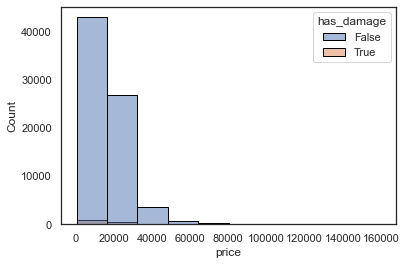

In [58]:
sns.histplot(train_data, x = 'price', hue = 'has_damage', bins = 10, edgecolor='black')
plt.show()

As we can see in the above histplot, the distribution for False or Nan (True) is similar, which again means that there is no difference in price in having or not damage. We're choosing to replace every Nan value in has_damage for 0, so the column is irrelevant. We'll drop it once we do feature selection.

<a id="2.2.4.">    </a>
### 2.2.4. Remove outliers

In [59]:
# Define outlier columns
outlier_columns = ['mileage', 'tax', 'mpg', 'engine_size', 'previous_owners']

numeric_columns.remove('has_damage')
categorical_columns.append('has_damage')

print(f'All columns: {list(independent_columns)} \nNumerical: {numeric_columns} \nCategorical: {categorical_columns} \nOutlier columns: {outlier_columns}')

All columns: ['brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engine_size', 'previous_owners', 'has_damage'] 
Numerical: ['year', 'mileage', 'tax', 'mpg', 'engine_size', 'previous_owners'] 
Categorical: ['brand', 'model', 'transmission', 'fuel_type', 'has_damage'] 
Outlier columns: ['mileage', 'tax', 'mpg', 'engine_size', 'previous_owners']


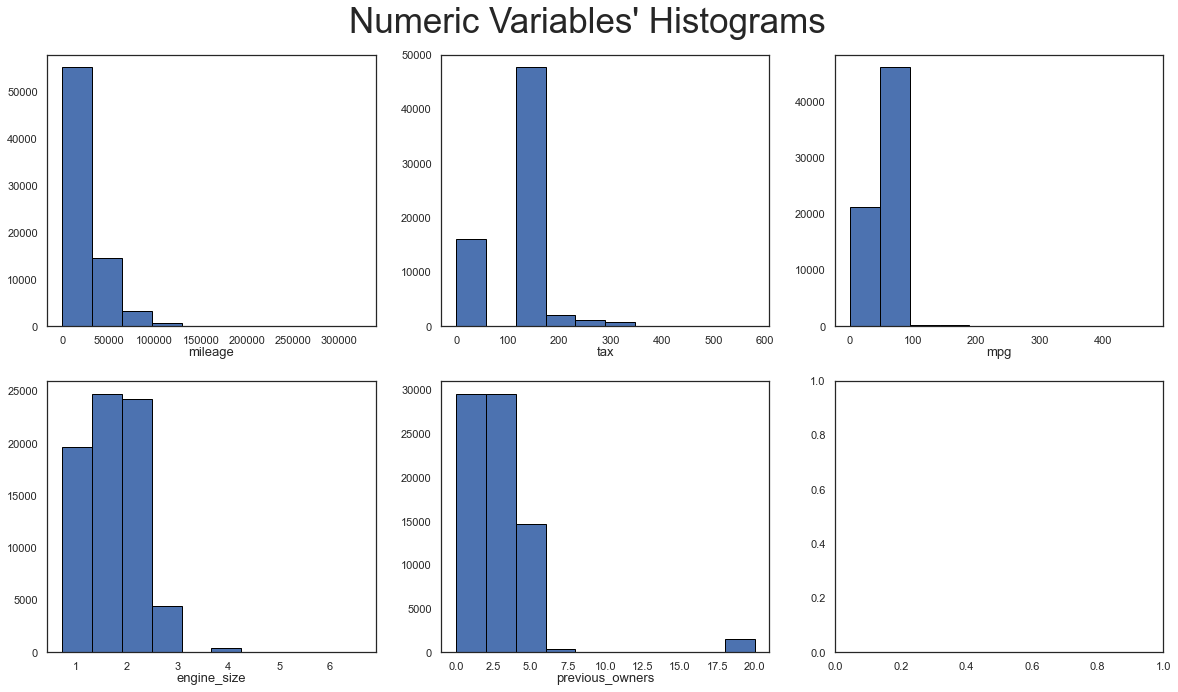

In [60]:
# Plot ALL Numeric Variables' Histograms in one figure
sp_rows = 2
sp_cols = 3

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), outlier_columns):
    ax.hist(train_data[feat], edgecolor='black')
    ax.set_title(feat, y=-0.13, fontsize=13)
    
# Layout
title = "Numeric Variables' Histograms"
plt.suptitle(title, y=.94, fontsize=35)

plt.show()

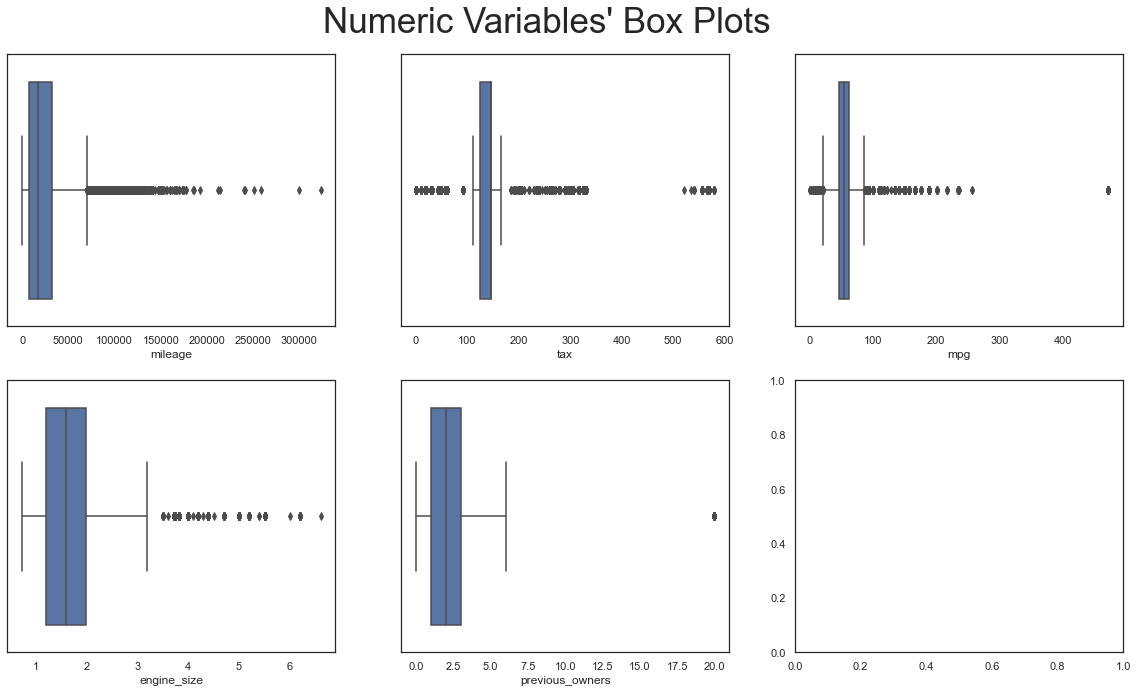

In [61]:
# Plot ALL Numeric Variables' Boxplots in one figure

sp_rows = 2
sp_cols = 3

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each boxplot:
for ax, feat in zip(axes.flatten(), outlier_columns):
    sns.boxplot(x=train_data[feat], ax=ax)
    
# Layout
title = "Numeric Variables' Box Plots"
plt.suptitle(title, y=.94, fontsize=35)

plt.show()

`Mileage, tax, mpg, engine size:` have a few outliers that we can remove

`Previous owners:` previously, we replaced the Nan values with an extreme value for us to handle it in the missing values section. Due to this replacement, we are now seeing this outlier, which we will ignore in this section and handle later

<a id="2.2.4.1.">    </a>
#### 2.2.4.1. Winsorizing the outliers in numeric columns

In [62]:
def winsor_bounds(s,k=1.5):
    """ This function calculates the quartiles and interquartile to perform winsorizing in the outliers."""

    q1,q3 = s.quantile([0.25,0.75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

In [63]:
def winsorizing(df):
    """ This function receives a cars DataFrame and winsorizes the outliers 
    in numeric columns by calling the winsor_bounds function."""

    cont_for_winsor = [c for c in ["mileage","mpg","engine_size","tax"] if c in df.columns]

    for c in cont_for_winsor:
        lo, hi = winsor_bounds(df[c].astype(float))
        df[c] = df[c].clip(lower=lo, upper=hi)

In [64]:
winsorizing(train_data)

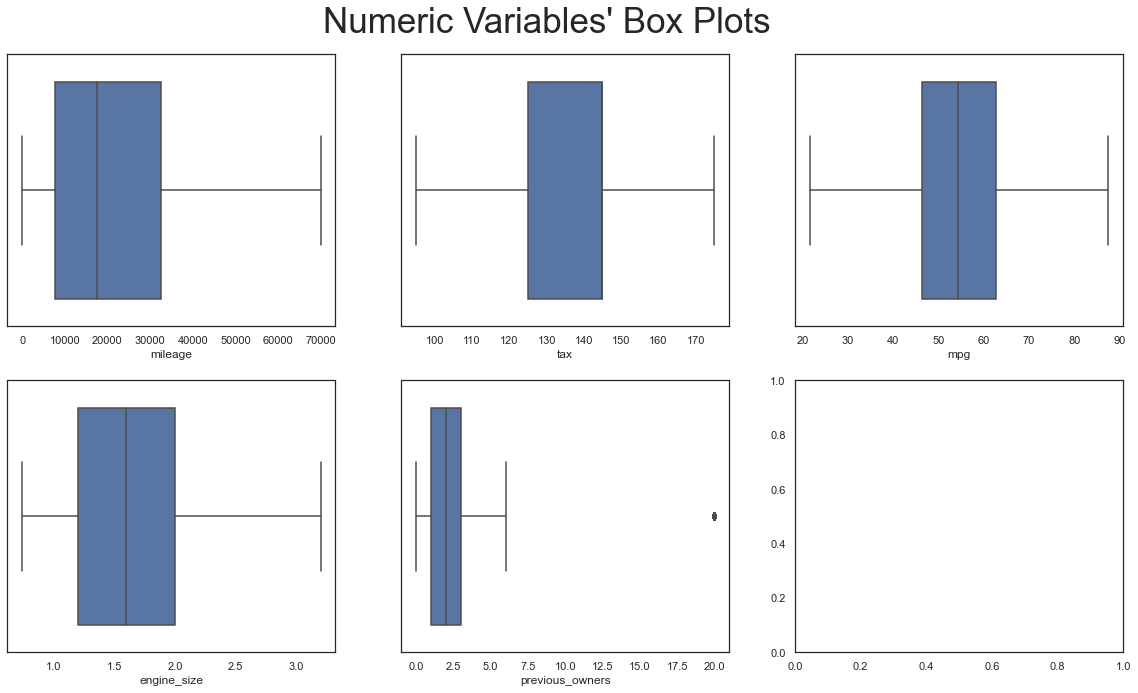

In [65]:
# Making sure that all the outliers were removed
# Plot ALL Numeric Variables' Boxplots in one figure

sp_rows = 2
sp_cols = 3

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each boxplot:
for ax, feat in zip(axes.flatten(), outlier_columns):
    sns.boxplot(x=train_data[feat], ax=ax)
    
# Layout
title = "Numeric Variables' Box Plots"
plt.suptitle(title, y=.94, fontsize=35)

plt.show()

<a id="2.2.5.">    </a>
### 2.2.5. Data separation

In [66]:
X = train_data.loc[:, list(independent_columns)]
y = train_data.loc[:,'price']

In [67]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size = 0.7, random_state = RSEED, shuffle = True)

<a id="2.2.6.">    </a>
### 2.2.6. Fill missing values

In [68]:
# Turn strings into the NaN in the categorical columns
for column in categorical_columns:
    X_train[column].replace('nan', np.nan, inplace=True)

In [69]:
# Bring back the NaN values in year, previous_owners and has_damage
X_train.year.replace(0, np.nan, inplace=True)
X_train.previous_owners.replace(20, np.nan, inplace=True)
X_train.has_damage.replace(True, np.nan, inplace=True)

In [70]:
X_train.isna().sum()

brand              1081
model              1060
year                 22
transmission       1076
mileage            1301
fuel_type          1030
tax                5577
mpg                5553
engine_size        1428
previous_owners    1107
has_damage         1077
dtype: int64

We need to fix: numeric and categorical columns.

<a id="2.2.6.1.">    </a>
#### 2.2.6.1. Has damage

In [71]:
# Replace the Nan values for 0
X_train.has_damage.replace(np.nan, 0, inplace=True)

<a id="2.2.6.2.">    </a>
#### 2.2.6.2. Numerical (KKN Imputer)

In [72]:
imputer = KNNImputer(n_neighbors=5).fit(X_train[numeric_columns])

In [73]:
filled_data = imputer.transform(X_train[numeric_columns])
filled_data

array([[2.0190e+03, 3.3036e+04, 1.5000e+02, 4.5600e+01, 2.0000e+00,
        0.0000e+00],
       [2.0170e+03, 2.4938e+04, 1.4500e+02, 6.7300e+01, 2.0000e+00,
        2.0000e+00],
       [2.0190e+03, 9.0000e+03, 1.4500e+02, 3.3200e+01, 3.0000e+00,
        1.0000e+00],
       ...,
       [2.0140e+03, 3.6223e+04, 1.7500e+02, 4.4800e+01, 3.0000e+00,
        0.0000e+00],
       [2.0160e+03, 3.2326e+04, 9.5000e+01, 5.7480e+01, 1.0000e+00,
        3.0000e+00],
       [2.0190e+03, 2.0893e+04, 1.5000e+02, 6.0100e+01, 1.0000e+00,
        0.0000e+00]])

In [74]:
filled_data_df = pd.DataFrame(filled_data, index=X_train.index, columns=numeric_columns)
filled_data_df['previous_owners'] = filled_data_df['previous_owners'].astype(int)
filled_data_df['year'] = filled_data_df['year'].astype(int)
filled_data_df

,year,mileage,tax,mpg,engine_size,previous_owners
car_id,,,,,,
16729,2019,33036.0,150.0,45.60,2.0,0
37306,2017,24938.0,145.0,67.30,2.0,2
9,2019,9000.0,145.0,33.20,3.0,1
38004,2017,16650.0,175.0,37.20,3.0,0
18199,2018,14363.0,146.0,62.32,1.0,0
...,...,...,...,...,...,...
15946,2018,31611.0,150.0,65.70,1.0,4
24523,2017,19512.0,149.0,62.76,1.0,2
1329,2014,36223.0,175.0,44.80,3.0,0


In [75]:
X_train = pd.concat([filled_data_df, X_train[categorical_columns]], axis=1)
X_train

,year,mileage,tax,mpg,engine_size,previous_owners,brand,model,transmission,fuel_type,has_damage
car_id,,,,,,,,,,,
16729,2019,33036.0,150.0,45.60,2.0,0,Ford,Mondeo,Semi-Auto,Diesel,False
37306,2017,24938.0,145.0,67.30,2.0,2,Mercedes,E-Class,Semi-Auto,Diesel,False
9,2019,9000.0,145.0,33.20,3.0,1,Audi,Q7,Automatic,Diesel,False
38004,2017,16650.0,175.0,37.20,3.0,0,Mercedes,GLS-Class,Semi-Auto,Diesel,False
18199,2018,14363.0,146.0,62.32,1.0,0,Ford,Focus,Manual,Petrol,False
...,...,...,...,...,...,...,...,...,...,...,...
15946,2018,31611.0,150.0,65.70,1.0,4,Ford,Fiesta,Manual,Petrol,False
24523,2017,19512.0,149.0,62.76,1.0,2,Ford,Focus,Manual,Petrol,False
1329,2014,36223.0,175.0,44.80,3.0,0,Audi,A6,Semi-Auto,Diesel,False


<a id="2.2.6.3.">    </a>
#### 2.2.6.3. Categorical

In [76]:
# Function which replaces the nan brands for the rows without nan models
def clean_brand(df):
    """ This function receives a car DataFrame as input and cleans the missing values 
    of brand in case that row as a model assigned and is not the only one in the DataFrame with that same model."""

    # Sort the dataframe by model and brand to easily identify similar entries
    df_sorted = df.sort_values(by=['model', 'brand'], ascending=[True, True])

    # Create a mask where 'model' is not NaN
    mask = df_sorted['model'].notna()

    # Forward fill only for rows where 'model' is not NaN and whose previous row is having the same model 
    df_sorted.loc[mask, 'brand'] = df_sorted.loc[mask].groupby('model')['brand'].ffill()        # Locate the brands for which model is not NaN and fill it with the above value
    
    # Replace brand values for the corresponding indexes
    df['brand'] = df_sorted['brand']
    
    #Fill brand using the brand_to_model dictionary for remaining NaN values
    for index in df.index:
        if pd.isna(df.loc[index, 'brand']) and (df.loc[index, 'model'] in models):
            for brand, model_list in brand_to_model.items():
                if df.loc[index, 'model'] in model_list:                      
                    df.loc[index, 'brand'] = brand
                    break                                                          
    return df

In [77]:
# Replace the nan brands for the rows with actual models
X_train = clean_brand(X_train)

Some of the Nan values in the brand column can be determined by the car's model (if not Nan) with the function above. The remaining ones, alongside the missing values in model, transmission and fuel type, were replaced for 'Unknown'.

In [78]:
# Replace remaining Nan for 'Unknown'
X_train.brand.replace(np.nan, 'Unknown', inplace=True)
X_train.model.replace(np.nan, 'Unknown', inplace=True)
X_train.transmission.replace(np.nan, 'Unknown', inplace=True)
X_train.fuel_type.replace(np.nan, 'Unknown', inplace=True)

However, we thought the 'Unknown' values in the model column could affect the model and so we removed them.

In [79]:
# Remove the rows with Unknown car models from the train set
X_train = X_train[X_train['model'] != 'Unknown']
y_train = y_train.loc[X_train.index]

<a id="2.2.6.4.">    </a>
#### 2.2.6.4. Confirmation

In [80]:
X_train.isna().sum()

year               0
mileage            0
tax                0
mpg                0
engine_size        0
previous_owners    0
brand              0
model              0
transmission       0
fuel_type          0
has_damage         0
dtype: int64

In [81]:
def clean_missing_values(df): 
    """ This function receives a car DataFrame (validation and test set), the mode of the year and a list of means and medians of the train set
     and cleans its missing values by replacing them with mean and median of the train set in case of numerical variables or with the mode or 'Unknown' in case of categorical"""

    # Turn strings into the NaN in the categorical columns
    for column in categorical_columns:
        df[column].replace('nan', np.nan, inplace=True)

    # Bring back the NaN values in year, previous_owners and has_damage
    df.year.replace('0', np.nan, inplace=True)
    df.previous_owners.replace(20, np.nan, inplace=True)
    df.has_damage.replace(True, np.nan, inplace=True)

    # Fill missing values with KNN Imputer
    filled_set_data = imputer.transform(df[numeric_columns])
    filled_set_data_df = pd.DataFrame(filled_set_data, index=df.index, columns=numeric_columns)
    filled_set_data_df['previous_owners'] = filled_set_data_df['previous_owners'].astype(int)
    df = pd.concat([filled_set_data_df, df[categorical_columns]], axis=1)

    # Fill the missing values in has_damage with 0
    df.has_damage.replace(np.nan, 0, inplace=True)

    # Fill the missing values in brands using ffill in case that row is having a model assigned
    df = clean_brand(df) 

    # Fill the remaining missing values in brands with 'Unknown'
    df.brand.replace(np.nan, 'Unknown', inplace=True)

    # Fill the missing values in models with 'Unknown'
    df.model.replace(np.nan, 'Unknown', inplace=True)

    # Fill the missing values in transmission with 'Unknown'
    df.transmission.replace(np.nan, 'Unknown', inplace=True)

    # Fill the missing values in fuel_type with 'Unknown'
    df.fuel_type.replace(np.nan, 'Unknown', inplace=True)

    return df

In [82]:
X_validation = clean_missing_values(X_validation)

In [83]:
X_validation.isna().sum()

year               0
mileage            0
tax                0
mpg                0
engine_size        0
previous_owners    0
brand              0
model              0
transmission       0
fuel_type          0
has_damage         0
dtype: int64

In [84]:
# Remove the rows with Unknown car models from the validation set
X_validation = X_validation[X_validation['model'] != 'Unknown']
y_validation = y_validation.loc[X_validation.index]

<a id="3.">    </a>
# 3. Regression Benchmarking

<a id="3.1.">    </a>
## 3.1. Feature engineering

In [85]:
X_train_num = X_train[numeric_columns]
X_train_cat = X_train[categorical_columns]

X_val_num = X_validation[numeric_columns]
X_val_cat = X_validation[categorical_columns]

<a id="3.1.1.">    </a>
### 3.1.1. (Re)check correlation

In [86]:
X_train.drop(columns = ['brand', 'model', 'transmission', 'fuel_type']).corr(method = 'spearman')

,year,mileage,tax,mpg,engine_size,previous_owners
year,1.000000,-0.762965,0.334503,-0.324549,-0.038248,-0.000160
mileage,-0.762965,1.000000,-0.278527,0.336439,0.098347,0.002773
tax,0.334503,-0.278527,1.000000,-0.537841,0.129530,0.005080
mpg,-0.324549,0.336439,-0.537841,1.000000,-0.198848,-0.004930
engine_size,-0.038248,0.098347,0.129530,-0.198848,1.000000,0.002263
previous_owners,-0.000160,0.002773,0.005080,-0.004930,0.002263,1.000000


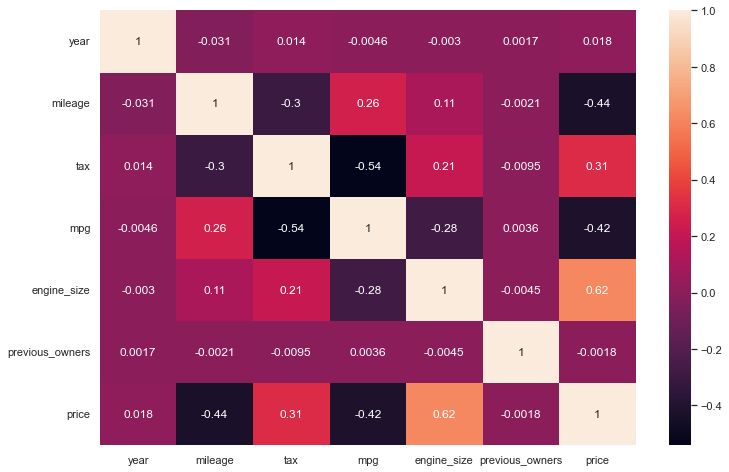

In [87]:
# Doing the correlation matrix for the numerical columns
correlation_list = numeric_columns+['price']
correlation_matrix = train_data[correlation_list].corr()
correlation_matrix

# Prepare figure
fig = plt.figure(figsize=(12, 8))

# Plot heatmap of the correlation matrix
sns.heatmap(data=correlation_matrix, annot=True)

plt.show()

Engine Size continues to have the highest correlation with price.

<a id="3.1.2.">    </a>
### 3.1.2. Change columns

We create a new variable, car_age, that calculates how old the car is.

In [88]:
X_train['car_age'] = 2025 - X_train['year']

In [89]:
X_train.head()

,year,mileage,tax,mpg,engine_size,previous_owners,brand,model,transmission,fuel_type,has_damage,car_age
car_id,,,,,,,,,,,,
16729,2019,33036.0,150.0,45.60,2.0,0,Ford,Mondeo,Semi-Auto,Diesel,False,6
37306,2017,24938.0,145.0,67.30,2.0,2,Mercedes,E-Class,Semi-Auto,Diesel,False,8
9,2019,9000.0,145.0,33.20,3.0,1,Audi,Q7,Automatic,Diesel,False,6
38004,2017,16650.0,175.0,37.20,3.0,0,Mercedes,GLS-Class,Semi-Auto,Diesel,False,8
18199,2018,14363.0,146.0,62.32,1.0,0,Ford,Focus,Manual,Petrol,False,7


So, we are going to drop the column year, since the car_age is more useful for future calculations and easier to interpret.

In [90]:
X_train.drop('year', axis=1, inplace=True)
numeric_columns.remove('year')

We are also going to drop the column has_damage, because all the values are 0 and it has a Nan correlation with the other variables (is irrelevant).

In [91]:
X_train.drop('has_damage', axis=1, inplace=True)

In [92]:
# Updated the numerical columns list
numeric_columns.append('car_age')

# Update the df with the numerical columns only
X_train_num = X_train[numeric_columns]

In [93]:
X_train.head()

,mileage,tax,mpg,engine_size,previous_owners,brand,model,transmission,fuel_type,car_age
car_id,,,,,,,,,,
16729,33036.0,150.0,45.60,2.0,0,Ford,Mondeo,Semi-Auto,Diesel,6
37306,24938.0,145.0,67.30,2.0,2,Mercedes,E-Class,Semi-Auto,Diesel,8
9,9000.0,145.0,33.20,3.0,1,Audi,Q7,Automatic,Diesel,6
38004,16650.0,175.0,37.20,3.0,0,Mercedes,GLS-Class,Semi-Auto,Diesel,8
18199,14363.0,146.0,62.32,1.0,0,Ford,Focus,Manual,Petrol,7


In [94]:
# Update categorical and numerical columns list
categorical_columns.remove('has_damage')

# Update the df with the categorical columns and numerical columns
X_train_cat = X_train[categorical_columns]
X_train_num = X_train[numeric_columns]

In [95]:
def change_columns(df):
    """ This function receives a cars DataFrame and adds a new column car_age which calculates the car's age given its year
    and drops unnecessary and redundant columns such as has_damage and year"""

    df['car_age'] = 2025 - df['year']
    df.drop('year', axis=1, inplace=True)
    df.drop('has_damage', axis=1, inplace=True)
    
    return df

In [96]:
X_validation = change_columns(X_validation)
X_val_num = X_validation[numeric_columns]
X_val_cat = X_validation[categorical_columns]

<a id="3.2.">    </a>
## 3.2. Modelling (create a predictive model)

<a id="3.2.1.">    </a>
### 3.2.1. Scaling

<a id="3.2.1.1.">    </a>
#### 3.2.1.1. MinMax Scaler

In [97]:
#call function
scaler_MinMax = MinMaxScaler()

#fit to training data
scaler_MinMax.fit(X_train_num)

#transform the data
X_train_num_MinMax = scaler_MinMax.transform(X_train_num) 

#show results
X_train_num_MinMax

array([[0.47222962, 0.6875    , 0.36439394, 0.51228753, 0.        ,
        0.05555556],
       [0.35647011, 0.625     , 0.69318182, 0.51228753, 0.33333333,
        0.07777778],
       [0.12863915, 0.625     , 0.17651515, 0.91871459, 0.16666667,
        0.05555556],
       ...,
       [0.51778723, 1.        , 0.35227273, 0.91871459, 0.        ,
        0.11111111],
       [0.46208029, 0.        , 0.54439394, 0.10586047, 0.5       ,
        0.08888889],
       [0.29864753, 0.6875    , 0.58409091, 0.10586047, 0.        ,
        0.05555556]])

In [98]:
# Convert the array to a pandas dataframe
X_train_num_MinMax = pd.DataFrame(X_train_num_MinMax, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_MinMax

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
16729,0.472230,0.6875,0.364394,0.512288,0.000000,0.055556
37306,0.356470,0.6250,0.693182,0.512288,0.333333,0.077778
9,0.128639,0.6250,0.176515,0.918715,0.166667,0.055556
38004,0.237995,1.0000,0.237121,0.918715,0.000000,0.077778
18199,0.205302,0.6375,0.617727,0.105860,0.000000,0.066667
...,...,...,...,...,...,...
15946,0.451859,0.6875,0.668939,0.105860,0.666667,0.066667
24523,0.278906,0.6750,0.624394,0.105860,0.333333,0.077778
1329,0.517787,1.0000,0.352273,0.918715,0.000000,0.111111


In [99]:
# Repeating for validation
X_val_num_MinMax = scaler_MinMax.transform(X_val_num)
X_val_num_MinMax = pd.DataFrame(X_val_num_MinMax, columns = X_val_num.columns).set_index(X_validation.index)
X_val_num_MinMax.head(3)

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
40401,0.084397,0.650,0.485606,0.512288,0.166667,0.066667
45192,0.043013,0.625,0.391364,0.512288,0.333333,0.055556
75023,0.071460,0.625,0.399242,0.105860,0.500000,0.044444


<a id="3.2.1.2.">    </a>
#### 3.2.1.2. Standard Scaler

In [100]:
#call function
scaler_Std = StandardScaler()

#fit to training data
scaler_Std.fit(X_train_num)

#transform the data
X_train_num_Std = scaler_Std.transform(X_train_num)

#show results
X_train_num_Std

array([[ 0.56540464,  0.65432346, -0.78423779,  0.65677731, -1.40363778,
        -0.55812431],
       [ 0.13170616,  0.43966109,  1.08210286,  0.65677731, -0.00395201,
        -0.07305165],
       [-0.72187328,  0.43966109, -1.85071815,  2.58544515, -0.7037949 ,
        -0.55812431],
       ...,
       [ 0.7360884 ,  1.72763529, -0.85304297,  2.58544515, -1.40363778,
         0.65455735],
       [ 0.52737971, -1.70696257,  0.23751921, -1.27189054,  0.69589088,
         0.16948468],
       [-0.08492885,  0.65432346,  0.46285619, -1.27189054, -1.40363778,
        -0.55812431]])

In [101]:
# Convert the array to a pandas dataframe
X_train_num_Std = pd.DataFrame(X_train_num_Std, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_Std

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
16729,0.565405,0.654323,-0.784238,0.656777,-1.403638,-0.558124
37306,0.131706,0.439661,1.082103,0.656777,-0.003952,-0.073052
9,-0.721873,0.439661,-1.850718,2.585445,-0.703795,-0.558124
38004,-0.312168,1.727635,-1.506692,2.585445,-1.403638,-0.073052
18199,-0.434651,0.482594,0.653791,-1.271891,-1.403638,-0.315588
...,...,...,...,...,...,...
15946,0.489087,0.654323,0.944492,-1.271891,1.395734,-0.315588
24523,-0.158890,0.611391,0.691633,-1.271891,-0.003952,-0.073052
1329,0.736088,1.727635,-0.853043,2.585445,-1.403638,0.654557


In [102]:
# Repeating for validation
X_val_num_Std = scaler_Std.transform(X_val_num)
X_val_num_Std = pd.DataFrame(X_val_num_Std, columns = X_val_num.columns).set_index(X_validation.index)
X_val_num_Std.head(3)

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
40401,-0.887630,0.525526,-0.096186,0.656777,-0.703795,-0.315588
45192,-1.042675,0.439661,-0.631146,0.656777,-0.003952,-0.558124
75023,-0.936098,0.439661,-0.586423,-1.271891,0.695891,-0.800661


<a id="3.2.1.3.">    </a>
#### 3.2.1.3. Robust Scaler

In [103]:
#call function
scaler_Robust = RobustScaler()

#fit to training data
scaler_Robust.fit(X_train_num)

#transform the data
X_train_num_Robust = scaler_Robust.transform(X_train_num)

#show results
X_train_num_Robust

array([[ 0.63042476,  0.25      , -0.55414013,  0.5       , -1.        ,
        -0.66666667],
       [ 0.30289671,  0.        ,  0.82802548,  0.5       ,  0.        ,
         0.        ],
       [-0.34172444,  0.        , -1.34394904,  1.75      , -0.5       ,
        -0.66666667],
       ...,
       [ 0.75932472,  1.5       , -0.60509554,  1.75      , -1.        ,
         1.        ],
       [ 0.60170842, -2.5       ,  0.20254777, -0.75      ,  0.5       ,
         0.33333333],
       [ 0.13929447,  0.25      ,  0.36942675, -0.75      , -1.        ,
        -0.66666667]])

In [104]:
# Convert the array to a pandas dataframe
X_train_num_Robust = pd.DataFrame(X_train_num_Robust, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_Robust

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
16729,0.630425,0.25,-0.554140,0.50,-1.0,-0.666667
37306,0.302897,0.00,0.828025,0.50,0.0,0.000000
9,-0.341724,0.00,-1.343949,1.75,-0.5,-0.666667
38004,-0.032316,1.50,-1.089172,1.75,-1.0,0.000000
18199,-0.124815,0.05,0.510828,-0.75,-1.0,-0.333333
...,...,...,...,...,...,...
15946,0.572790,0.25,0.726115,-0.75,1.0,-0.333333
24523,0.083439,0.20,0.538854,-0.75,0.0,0.000000
1329,0.759325,1.50,-0.605096,1.75,-1.0,1.000000


In [105]:
# Repeating for validation
X_val_num_Robust = scaler_Robust.transform(X_val_num)
X_val_num_Robust = pd.DataFrame(X_val_num_Robust, columns = X_val_num.columns).set_index(X_validation.index)
X_val_num_Robust.head(3)

,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,
40401,-0.466903,0.1,-0.044586,0.50,-0.5,-0.333333
45192,-0.583993,0.0,-0.440764,0.50,0.0,-0.666667
75023,-0.503507,0.0,-0.407643,-0.75,0.5,-1.000000


<a id="3.2.1.4.">    </a>
#### 3.2.1.4. Comparison

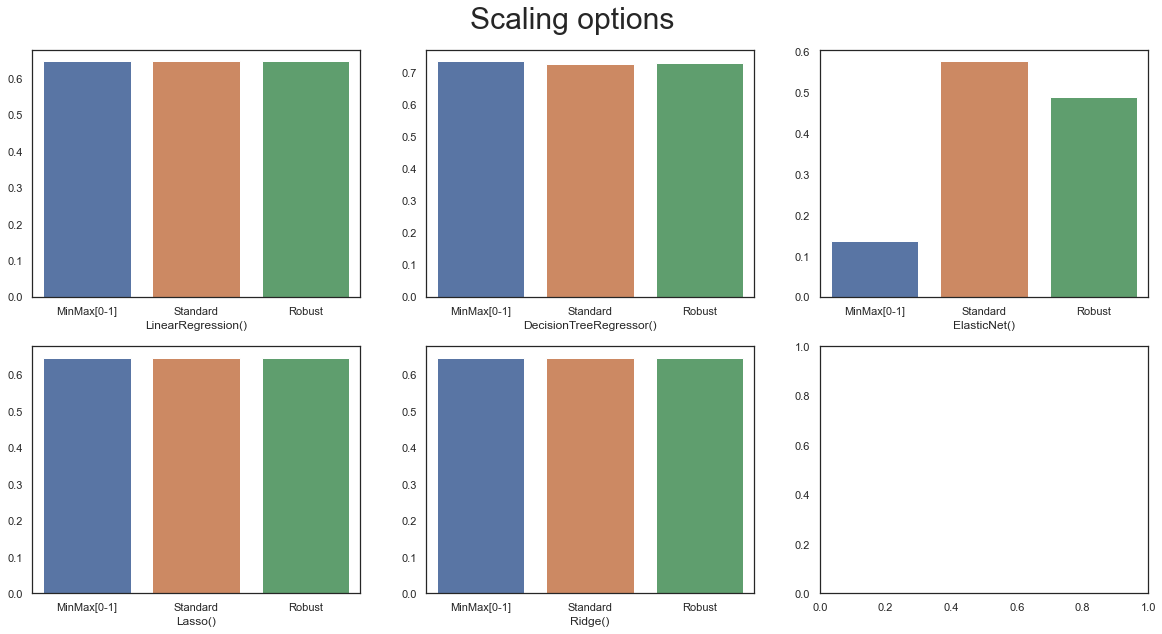

In [106]:
def standard_score(model_given, ax):
    """"Compare model performance across numeric scaling methods and plot a bar chart."""
    model_min_max1 = model_given.fit(X_train_num_MinMax, y_train)
    score_minmax = model_min_max1.score(X_val_num_MinMax, y_validation)

    model_std = model_given.fit(X_train_num_Std, y_train)
    score_std = model_std.score(X_val_num_Std, y_validation)

    model_Robust = model_given.fit(X_train_num_Robust, y_train)
    score_robust = model_Robust.score(X_val_num_Robust, y_validation)

    x = ['MinMax[0-1]','Standard','Robust']
    y = [score_minmax, score_std, score_robust]

    sns.barplot(x = x, y = y, ax = ax)

possible_models = [LinearRegression(), DecisionTreeRegressor(), ElasticNet(), Lasso(), Ridge()]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, model in zip(axes.flatten(), possible_models):
    standard_score(model, ax)
    ax.set_ylabel('')
    ax.set_xlabel(model)

plt.suptitle("Scaling options", y=0.94, fontsize=30)

plt.show()

Standard scaling presents the best scores among all the models, especially for ElasticNet, meaning that with this type of scaling the models correctly predict between 60 and 70% of the samples in the validation set.

<a id="3.2.2.">    </a>
### 3.2.2. Encoding

First let's encode our categorical variables using One-Hot Encoding.

In [107]:
X_train_ohc = X_train.copy()

In [108]:
# Use OneHotEncoder to encode the categorical features.
ohc = OneHotEncoder(sparse_output=False,                                # sparse_output=False outputs a numpy array, not a sparse matrix
                    drop="first", handle_unknown='ignore')              # drop the first category of each feature when performing one-hot encoding

In [109]:
# Get feature names and create a DataFrame with the one-hot encoded categorical features (pass feature names)
ohc_feat = ohc.fit_transform(X_train_ohc[categorical_columns])              # Fit to data then transform it
ohc_feat_names = ohc.get_feature_names_out()                                # Get output feature names from the transformation

In [110]:
ohc_X_train = pd.DataFrame(ohc_feat, index=X_train_ohc.index, columns=ohc_feat_names)
ohc_X_train

,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Opel,brand_Skoda,brand_Toyota,brand_VW,model_2 Series,model_200,...,model_ix35,transmission_Manual,transmission_Other,transmission_Semi-Auto,transmission_Unknown,fuel_type_Electric,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol,fuel_type_Unknown
car_id,,,,,,,,,,,,,,,,,,,,,
16729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18199,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Add the independent numerical variables
ohc_X_train = pd.concat([ohc_X_train, X_train_num_Std], axis=1)
ohc_X_train

,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Opel,brand_Skoda,brand_Toyota,brand_VW,model_2 Series,model_200,...,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol,fuel_type_Unknown,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,,,,,,,,,,,,,,,,
16729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.565405,0.654323,-0.784238,0.656777,-1.403638,-0.558124
37306,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.131706,0.439661,1.082103,0.656777,-0.003952,-0.073052
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.721873,0.439661,-1.850718,2.585445,-0.703795,-0.558124
38004,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.312168,1.727635,-1.506692,2.585445,-1.403638,-0.073052
18199,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.434651,0.482594,0.653791,-1.271891,-1.403638,-0.315588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.489087,0.654323,0.944492,-1.271891,1.395734,-0.315588
24523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.158890,0.611391,0.691633,-1.271891,-0.003952,-0.073052
1329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.736088,1.727635,-0.853043,2.585445,-1.403638,0.654557


In [112]:
def encoding(df, df_num_scaled):
    """This function receives a car's dataframe and its numerical features scaled version.
    It encodes the categorical features and then concatenates to the scaled numerical features. """

    df_ohc = df.copy()
    ohc_feat = ohc.transform(df_ohc[categorical_columns])               # Transform data
    ohc_feat_names = ohc.get_feature_names_out()
    ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
    ohc_df = pd.concat([ohc_df, df_num_scaled], axis=1)
    
    return ohc_df

In [113]:
# Encode the validation set
ohc_X_val = encoding(X_validation, X_val_num_Std)
ohc_X_val

,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Opel,brand_Skoda,brand_Toyota,brand_VW,model_2 Series,model_200,...,fuel_type_Hybrid,fuel_type_Other,fuel_type_Petrol,fuel_type_Unknown,mileage,tax,mpg,engine_size,previous_owners,car_age
car_id,,,,,,,,,,,,,,,,,,,,,
40401,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.887630,0.525526,-0.096186,0.656777,-0.703795,-0.315588
45192,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.042675,0.439661,-0.631146,0.656777,-0.003952,-0.558124
75023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.936098,0.439661,-0.586423,-1.271891,0.695891,-0.800661
53803,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1.015362,0.010336,0.256441,0.271044,-0.003952,-0.800661
49550,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.053654,0.439661,0.574665,-1.271891,-0.003952,-0.558124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28357,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.822720,-1.706963,0.256441,-1.271891,-1.403638,0.169485
69000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.358441,-0.418988,0.359648,0.656777,-0.003952,-0.073052
51938,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.331150,-1.706963,1.520736,0.271044,-1.403638,0.412021


<a id="3.2.3.">    </a>
### 3.2.3. Create a model

<a id="3.2.3.1.">    </a>
#### 3.2.3.1. Linear Regression

In [114]:
lin_model = LinearRegression()

In [115]:
# Fit the train dataset
lin_model.fit(ohc_X_train, y_train)

LinearRegression()

In [116]:
# Predict results for validation
predictions = lin_model.predict(ohc_X_val)
predictions

array([26375.1960842 , 27478.17513439, 14648.14135542, ...,
       15054.21197642, 14780.6577406 , 18605.74317425])

In [117]:
# Compare predicted results with real values
val_results = pd.DataFrame({'y_true': y_validation.values.flatten(), 'y_pred': predictions.flatten()}, 
                           index=y_validation.index            #ensures we can map the predictions to each observation correctly
                           )

val_results

,y_true,y_pred
car_id,,
40401,23799,26375.196084
45192,31499,27478.175134
75023,14999,14648.141355
53803,25000,24946.989198
49550,11795,12081.550495
...,...,...
28357,10700,14463.269325
69000,19490,21161.131955
51938,12095,15054.211976


In [118]:
# Training metrics
y_pred_train = lin_model.predict(ohc_X_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print('Training metrics:')
print(f'R²: {r2_train:.4f}')
print(f'MAE: {mae_train:.4f}')

Training metrics:
R²: 0.8211
MAE: 2653.1248


- R²: Around 80% of the variance in the price is explained by the features in the training dataset.
- MAE: On average, the model's predictions of the price are off by approximately 2650£ from the actual values in the training dataset.

In [119]:
# Validation metrics
y_pred_val = lin_model.predict(ohc_X_val)
r2_val = r2_score(y_validation, y_pred_val)
mae_val = mean_absolute_error(y_validation, y_pred_val)

print('Validation metrics:')
print(f'R²: {r2_val:.4f}')
print(f'MAE: {mae_val:.4f}')

Validation metrics:
R²: 0.8161
MAE: 2680.1681


- R²: Around 80% of the variance in the price is explained by the features in the validation data. This result doesn't fall much behind from the training set, meaning the model generalizes well to unseen data. 
- MAE: Predictions on the validation dataset have an average error of around 2680£ from the true values, which is also very close to the training. This indicates that the model performs well on both training and validation set.

<a id="3.2.3.2.">    </a>
#### 3.2.3.2. Linear Regression Variants

<a id="3.2.3.2.1.">    </a>
##### 3.2.3.2.1. Ridge Regression (L2 Regularization)

In [120]:
# First: Create Ridge regression model with alpha=1.0
ridge_model = Ridge(alpha=1.0)

# Second: Fit the model
ridge_model.fit(ohc_X_train, y_train)

# Third: Make predictions
y_pred_ridge_train = ridge_model.predict(ohc_X_train)
y_pred_ridge_val = ridge_model.predict(ohc_X_val)

# Fourth: Evaluate the model
print("Ridge Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_ridge_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_ridge_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_ridge_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_ridge_val):.2f}")
print(f"\nIntercept: {ridge_model.intercept_:.2f}")
print("Coefficients:")
for feature, coef in zip(X_train.columns, ridge_model.coef_):
    print(f"  {feature}: {coef:.4f}")

Ridge Regression Results:
Training R²: 0.8207
Validation R²: 0.8152
Training MAE: 2659.49
Validation MAE: 2683.65

Intercept: 25918.99
Coefficients:
  mileage: -9468.9509
  tax: -10156.8664
  mpg: -11818.1777
  engine_size: -870.5296
  previous_owners: -12891.4826
  brand: -10064.7092
  model: -8373.2307
  transmission: -6875.5851
  fuel_type: 495.6578
  car_age: -3725.2991


According to the Ridge regression model, a 1 mile increase in mileage is expected to decrease the price by around 9480£, holding all other variables constant.

And a 1 year increase in car age is expected to decrease price by around 3730£, holding all other variables constant.

<a id="3.2.3.2.2.">    </a>
##### 3.2.3.2.2. Lasso Regression (L1 Regularization)

In [121]:
# First: Create Lasso regression model with alpha=1.0
lasso_model = Lasso(alpha=1.0, max_iter=10000)

# Second: Fit the model
lasso_model.fit(ohc_X_train, y_train)

# Third: Make predictions
y_pred_lasso_train = lasso_model.predict(ohc_X_train)
y_pred_lasso_val = lasso_model.predict(ohc_X_val)

# Fourth: Evaluate the model
print("Lasso Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_lasso_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_lasso_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_lasso_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_lasso_val):.2f}")
print(f"\nIntercept: {lasso_model.intercept_:.2f}")
print("Coefficients:")
for feature, coef in zip(X_train.columns, lasso_model.coef_):
    print(f"  {feature}: {coef:.4f}")

Lasso Regression Results:
Training R²: 0.8182
Validation R²: 0.8132
Training MAE: 2690.24
Validation MAE: 2706.68

Intercept: 20887.83
Coefficients:
  mileage: -3525.2530
  tax: -5098.8614
  mpg: -6616.2444
  engine_size: -0.0000
  previous_owners: -8123.2930
  brand: -6034.8854
  model: -4977.6148
  transmission: -2717.5574
  fuel_type: -285.7473
  car_age: -0.0000


According to the Lasso Regression model, on the other hand: the car age is having little to no impact in the price, which is unrealistic, contrary to the other models.

<a id="3.2.3.2.3.">    </a>
##### 3.2.3.2.3. Elastic Net Regression (L1 + L2 Regularization)

In [122]:
# Create Elastic Net model with alpha=1.0 and l1_ratio=0.5 (equal mix of L1 and L2)
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000)

# Fit the model
elastic_model.fit(ohc_X_train, y_train)

# Make predictions
y_pred_elastic_train = elastic_model.predict(ohc_X_train)
y_pred_elastic_val = elastic_model.predict(ohc_X_val)

# Evaluate the model
print("Elastic Net Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_elastic_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_elastic_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_elastic_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_elastic_val):.2f}")
print(f"\nIntercept: {elastic_model.intercept_:.2f}")
print("Coefficients:")
for feature, coef in zip(X_train.columns, elastic_model.coef_):
    print(f"  {feature}: {coef:.4f}")

Elastic Net Regression Results:
Training R²: 0.6380
Validation R²: 0.6327
Training MAE: 3743.95
Validation MAE: 3789.21

Intercept: 17915.11
Coefficients:
  mileage: 341.5409
  tax: -403.9083
  mpg: -238.7829
  engine_size: 862.9802
  previous_owners: -896.7319
  brand: -148.9572
  model: -215.0991
  transmission: 18.3614
  fuel_type: -5.7196
  car_age: -0.0000


According to the Elastic Net Regression Model, on the contrary with the other models, a 0.1 cc increase of engine size is expected to increase price by around 860£. 

Similarly to the Lasso Regression model, car age is having little to no impact in the price, which is unrealistic.

<a id="3.2.3.3.">    </a>
#### 3.2.3.3. Decision Tree Regressor

In [123]:
# First: Initialize the Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=4, random_state=RSEED)

In [124]:
# Second: Train the model
regressor.fit(ohc_X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [125]:
# Third: Predict on train set
y_train_pred_tree = regressor.predict(ohc_X_train)

In [126]:
r2_tree = r2_score(y_train, y_train_pred_tree)
print(f"R-squared: {r2_tree}")

mae_tree = mean_absolute_error(y_train, y_train_pred_tree)
print(f"Mean Absolute Error: {mae_tree}")

R-squared: 0.7102072253840435
Mean Absolute Error: 3521.597638369843


With the default parameters:
- R²: Around 70% of the variance in the price is explained by the features in the training dataset.
- MAE: On average, the model's predictions of the price are off by approximately 3520£ from the actual values in the training dataset.

In [127]:
# Fourth: Predict on the validation set
y_val_pred_tree = regressor.predict(ohc_X_val)

In [128]:
r2_tree = r2_score(y_validation, y_val_pred_tree)
print(f"R-squared: {r2_tree}")

mae_tree = mean_absolute_error(y_validation, y_val_pred_tree)
print(f"Mean Absolute Error: {mae_tree}")

R-squared: 0.7017989183874542
Mean Absolute Error: 3567.186453210402


- R²: Around 70% of the variance in the price is explained by the features in the validation data. This result doesn't fall much behind from the training set, meaning the model generalizes well to unseen data. 
- MAE: Predictions on the validation dataset have an average error of around 3570£ from the true values, which is also very close to the training. This indicates that the model performs well on both training and validation set.

However, this is not the best predicting results we got so far.

<a id="3.2.4.">    </a>
### 3.2.4. Feature Selection

<a id="3.2.4.1.">    </a>
#### 3.2.4.1. Decision Tree Regressor - Feature importance

In [ ]:
mse_importance = DecisionTreeRegressor(random_state=RSEED).fit(ohc_X_train, y_train).feature_importances_
mae_importance = DecisionTreeRegressor(criterion='absolute_error', random_state=RSEED).fit(ohc_X_train, y_train).feature_importances_

results_df = pd.DataFrame({
    'Feature': ohc_X_train.columns,
    'MSE': mse_importance,
    'MAE': mae_importance
})
results_df

Let's group the results corresponded to each categorical feature by brand, model, transmission and fuel_type:

In [ ]:
# Get the original categorical column name to group by it and then sum the importance
def group_by_cat_name(column):
    """ This function receives a encoded categorical column name returns the categorical original column name to later group by it and calculate the sum of importance (mae and mse)."""
    if column.startswith('model_'):
        return 'model'
    if column.startswith('brand_'):
        return 'brand'
    if column.startswith('transmission_'):
        return 'transmission'
    if column.startswith('fuel_type_'):
        return 'fuel_type'
    # If its a numerical column, return its own name
    return column

importance_df = results_df.assign(Feature = results_df['Feature'].map(group_by_cat_name)).groupby('Feature', as_index=False)[['MSE', 'MAE']].sum()

importance_df.sort_values(by=['MAE', 'MSE'], ascending=False)

In [ ]:
importance_melted = importance_df.melt(id_vars='Feature', var_name='Criterion', value_name='Importance')
avg_order = importance_melted.groupby('Feature')['Importance'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_melted,
    y='Feature',
    x='Importance',
    hue='Criterion',
    order=avg_order.index
)

# add vertical threshold line at 0.05
threshold = 0.05
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)

plt.title('Feature importance comparison (MSE vs MAE)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

So from this feature importance analysis we can conclude the following:
- To minimize MSE, the key drivers are orderly: **`transmission`**, **`engine_size`**, **`car_age`** and **`model`**. Together their summed importance tops 80%.
- To minimize MAE, the key drivers are orderly: **`car_age`**, **`transmission`**, **`engine_size`** and **`mileage`**.

The remaining features, **`fuel_type`**, **`tax`**, **`previous_owners`** and **`brand`**, have all roughly less than 5% importance to minimize both MSE and MAE.

<a id="3.2.4.2.">    </a>
#### 3.2.4.2. Attributes of Linear Regression

In [ ]:
coefs = pd.DataFrame(lin_model.coef_)
coefs = coefs.set_index(ohc_X_train.columns)
coefs

In [ ]:
# Check coefficients for all the car brands
coefs[0: 8]

According to the calculated coefficients:
- When it's Opel it's expected to decrease the reference price by a considerable amount of around 13K£. It's the least valued of all the brands.
- When it's Mercedes it's expected to decrease the reference price by around 1030£. It's the most valued of all the brands.

In [ ]:
# Intercept of linear regression
lin_model.intercept_

If all independent variables (features tax, mpg, engine_size, etc.) were zero, the model predicts that the estimated price would be around 25940£.

<a id="3.2.4.3.">    </a>
#### 3.2.4.3. P-values

In [ ]:
# Compare with sklearn coefficients
sk_coef = np.concatenate(([lin_model.intercept_], np.asarray(lin_model.coef_).ravel()))
print('\nSklearn intercept and coefficients:')
print(pd.Series(sk_coef, index=['Intercept'] + list(ohc_X_train.columns)))

- A unit increase of engine_size and previous_owners is expected to increase the price by around 2450£ and 30£, respectively.
- For each increase in car_age, the price tends to decrease around 720£.

In [ ]:
# Statsmodels (full statistical summary)
# Align the indices of X and y
ohc_X_train_aligned, y_train_aligned = ohc_X_train.align(y_train, join='inner', axis=0)

X_sm = sm.add_constant(ohc_X_train_aligned)
ols = sm.OLS(y_train_aligned, X_sm).fit()
print(ols.summary())

Each car brand is having a high p-value (> 0.2) which indicates **there's no sufficient** statistical evidence in the dataset that suggests a significant relationship between these brands and price.

Many models such as 200, 230, B-Class, B-Max also present a high p-value.

Models such as M2, M3 and M4, however, seem to present a p-value lower than the conventional significance level (0.05), suggesting that there's an extremely strong evidence of a strong significant relationship between these models and price.

In [ ]:
# Get the p-values and filter by significance (e.g., > 0.05)
significant_vars = ols.pvalues[ols.pvalues > 0.05]

# Filter to only those whose names start with 'model'
significant_model_vars = significant_vars[significant_vars.index.str.startswith('model')]

# Get the coefficients for these filtered models with small p-value
significant_model_coefs = ols.params[significant_model_vars.index]

significant_model_coefs

All the above models have a high p-value for the relationship between them and the price. Meaning, we cannot reject the null hypothesis of their effect on price being zero, for example:
$$H_0:β_{A-Class} = 0$$

However, for a lot of these car models there's a combination of large coefficient, standard errors, high p-value and wide interval, which can suggest the presence of multi-collinearity, meaning our features/estimators are dependent of one another. Therefore, this analysis becomes insufficient or uninterpretable.

Nevertheless, while analyzing the importance of each feature with DecisionTreeRegressor we selected model (sum of all models importance) as one of the most important features to minimize both MSE and MAE.


Given these, we'll opt to drop only **`previous_owners`** and the **`brand`** column.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Features to drop
brands_columns = [col for col in ohc_X_train.columns if col.startswith('brand_')]

remove_features = ['previous_owners'] + brands_columns 

In [ ]:
# Function to drop features we deemed unnecessary during feature selection
def drop_unnecessary_features(df, features_to_drop):
    """ This function receives a car DataFrame and a list of unnecessary features selected during Feature Selection and drops those features from the dataframes."""
    
    df = df.drop(columns=features_to_drop)
    
    return df

In [ ]:
# Drop unnecessary features from train and validation sets
ohc_X_train = drop_unnecessary_features(ohc_X_train, remove_features)
ohc_X_val = drop_unnecessary_features(ohc_X_val, remove_features)

<a id="3.2.5.">    </a>
### 3.2.5. Re-fit Models

<a id="3.2.5.1.">    </a>
#### 3.2.5.1. Linear Regression

In [ ]:
# Re-fit linear regression model after feature selection
lin_model.fit(ohc_X_train, y_train)

# Predict on train and get the score and MAE
y_pred_train = lin_model.predict(ohc_X_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print('Training metrics:')
print(f'R²: {r2_train:.4f}')
print(f'MAE: {mae_train:.4f}')

In [ ]:
# Repeat for validation set
y_pred_val = lin_model.predict(ohc_X_val)
r2_val = r2_score(y_validation, predictions)
mae_val = mean_absolute_error(y_validation, predictions)

print('Validation metrics:')
print(f'R²: {r2_val:.4f}')
print(f'MAE: {mae_val:.4f}')

<a id="3.2.5.2.">    </a>
#### 3.2.5.2. Ridge Regression

In [ ]:
# Re-fit Fit the model
ridge_model.fit(ohc_X_train, y_train)

# Make predictions
y_pred_ridge_train = ridge_model.predict(ohc_X_train)
y_pred_ridge_val = ridge_model.predict(ohc_X_val)

# Evaluate the model
print("Ridge Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_ridge_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_ridge_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_ridge_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_ridge_val):.2f}")

<a id="3.2.5.3.">    </a>
#### 3.2.5.3. Lasso Regression

In [ ]:
# Re-fit the model
lasso_model.fit(ohc_X_train, y_train)

# Third: Make predictions
y_pred_lasso_train = lasso_model.predict(ohc_X_train)
y_pred_lasso_val = lasso_model.predict(ohc_X_val)

# Fourth: Evaluate the model
print("Lasso Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_lasso_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_lasso_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_lasso_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_lasso_val):.2f}")

<a id="3.2.5.4.">    </a>
#### 3.2.5.4. Elastic Net Regression (L1 + L2 Regularization)

In [ ]:
# Re-fit the model
elastic_model.fit(ohc_X_train, y_train)

# Make predictions
y_pred_elastic_train = elastic_model.predict(ohc_X_train)
y_pred_elastic_val = elastic_model.predict(ohc_X_val)

# Evaluate the model
print("Elastic Net Regression Results:")
print(f"Training R²: {r2_score(y_train, y_pred_elastic_train):.4f}")
print(f"Validation R²: {r2_score(y_validation, y_pred_elastic_val):.4f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_elastic_train):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_validation, y_pred_elastic_val):.2f}")

<a id="3.2.5.5.">    </a>
#### 3.2.5.5. DecisionTreeRegressor

In [ ]:
dt_mse_ctrl = DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=RSEED)
dt_mae_ctrl = DecisionTreeRegressor(criterion='absolute_error', max_depth=5, random_state=RSEED)

dt_mse_ctrl.fit(ohc_X_train, y_train)
dt_mae_ctrl.fit(ohc_X_train, y_train)

print(f"{'Model':<10}{'Train R^2':>12}{'Val R^2':>12}")
print(f"{'MSE':<10}{dt_mse_ctrl.score(ohc_X_train, y_train):>12.3f}{dt_mse_ctrl.score(ohc_X_val, y_validation):>12.3f}")
print(f"{'MAE':<10}{dt_mae_ctrl.score(ohc_X_train, y_train):>12.3f}{dt_mae_ctrl.score(ohc_X_val, y_validation):>12.3f}")

With the MSE as criterion we obtain a $R^2$ of around 0.77 and 0.75 for the train and validation set, meaning that in this case our independent features explain collectively about around 77% of the variability in the target.

With MAE we get around 1-2% less of $R^2$. Given this, we'll opt for **`criterion='squared_error'`**.

In [ ]:
n_max_depth = range(1, 16)

score_list_train = []
score_list_val = []        
mae_list_train =[]
mae_list_val =[]
for n in n_max_depth:

    model = DecisionTreeRegressor(criterion='squared_error', max_depth=n, random_state=RSEED).fit(ohc_X_train, y_train)

    pred_train_knn = model.predict(ohc_X_train)
    pred_val_knn = model.predict(ohc_X_val)

    score_train = model.score(ohc_X_train, y_train)
    score_val = model.score(ohc_X_val, y_validation)

    score_list_train.append(score_train)
    score_list_val.append(score_val)

    error_train = mean_absolute_error(y_train, pred_train_knn)
    error_val = mean_absolute_error(y_validation, pred_val_knn)

    mae_list_train.append(error_train)
    mae_list_train.append(error_val)

    print('Max Depth: ' + str(n) + '\n')
    print('Train score: ' + str(round(score_train, 4)))
    print('Validation score ' + str(round(score_val, 4)))
    print("Score difference train and validation:", str(round(score_train - score_val, 4))+ '\n')
    print('Train Mean squared error: ' + str(round(error_train, 4)))
    print('Validation Mean squared error: ' + str(round(error_val, 4)))
    print("MSE difference train and validation:", str(round(error_val - error_train, 4)))
    print('....................')

Our best option for max_depth is 10, as after that, the model starts to overfit on the training set.

In [ ]:
# First: Initialize the Decision Tree Regressor and fit on train
dtr_model = DecisionTreeRegressor(criterion='squared_error', max_depth=10, random_state=RSEED).fit(ohc_X_train, y_train)

In [ ]:
# Second: Predict on train set and evaluate
y_train_pred_tree = dtr_model.predict(ohc_X_train)

r2_tree = r2_score(y_train, y_train_pred_tree)
print(f"R-squared: {r2_tree}")

mae_tree = mean_absolute_error(y_train, y_train_pred_tree)
print(f"Mean Absolute Error: {mae_tree}")

In [ ]:
# Third: Predict on the validation set and evaluate
y_val_pred_tree = dtr_model.predict(ohc_X_val)


r2_tree = r2_score(y_validation, y_val_pred_tree)
print(f"R-squared: {r2_tree}")

mae_tree = mean_absolute_error(y_validation, y_val_pred_tree)
print(f"Mean Absolute Error: {mae_tree}")

<a id="3.2.5.6.">    </a>
#### 3.2.5.6. KNeighborsRegressor

Let's look for the best solution by identifying the optimal number of neighbors to select:

In [ ]:
numberK_list=np.arange(1,15)

score_list_train = []
score_list_val = []        
mae_list_train =[]
mae_list_val =[]

for n in numberK_list:

    model = KNeighborsRegressor(n_neighbors = n).fit(ohc_X_train, y_train)

    pred_train_knn = model.predict(ohc_X_train)
    pred_val_knn = model.predict(ohc_X_val)

    score_train = model.score(ohc_X_train, y_train)
    score_val = model.score(ohc_X_val, y_validation)

    score_list_train.append(score_train)
    score_list_val.append(score_val)

    error_train = mean_absolute_error(y_train, pred_train_knn)
    error_val = mean_absolute_error(y_validation, pred_val_knn)

    mae_list_train.append(error_train)
    mae_list_val.append(error_val)

    print('Number of neighbors: ' + str(n) + '\n')
    print('Train score: ' + str(round(score_train, 4)))
    print('Validation score ' + str(round(score_val, 4)))
    print("Score difference train and validation:", str(round(score_train - score_val, 4))+ '\n')
    print('Train Mean absolute error: ' + str(round(error_train, 4)))
    print('Validation Mean absolute error: ' + str(round(error_val, 4)))
    print("MAE difference train and validation:", str(round(error_val - error_train, 4)))
    print('....................')

In [ ]:
plt.plot(numberK_list, mae_list_train, label='Train')
plt.plot(numberK_list, mae_list_val, label = 'Validation')
plt.xticks(numberK_list)
plt.legend()

After K = 7, the MAE starts to increase for both train and validation set.

We'll go with K = 6 as both sets seem to be closer to each other at this point before the start of the MAE increase.

In [ ]:
KNR_model = KNeighborsRegressor(n_neighbors = 6, p=1).fit(ohc_X_train, y_train)

pred_train_knr = KNR_model.predict(ohc_X_train)
pred_val_knr = KNR_model.predict(ohc_X_val)

knr_score_train = KNR_model.score(ohc_X_train, y_train)
knr_score_val = KNR_model.score(ohc_X_val, y_validation)

knr_error_train = mean_absolute_error(y_train, pred_train_knr)
knr_error_val = mean_absolute_error(y_validation, pred_val_knr)

# Dataframe to display these values
pd.DataFrame({
    'Set' : ['Train', 'Validation'],
    'Score' : [knr_score_train, knr_score_val],
    'MAE' : [knr_error_train, knr_error_val]
})

<a id="3.2.5.7.">    </a>
#### 3.2.5.7. Random Forest Regressor

In [ ]:
n_estim_list=np.arange(200, 401, 50)

score_list_train = []
score_list_val = []        
mae_list_train =[]
mae_list_val =[]

for n in n_estim_list:

    model = RandomForestRegressor(n_estimators = n, max_depth=None, random_state=RSEED, n_jobs=-1).fit(ohc_X_train, y_train)

    pred_train_rf = model.predict(ohc_X_train)
    pred_val_rf = model.predict(ohc_X_val)

    score_train = model.score(ohc_X_train, y_train)
    score_val = model.score(ohc_X_val, y_validation)

    score_list_train.append(score_train)
    score_list_val.append(score_val)

    error_train = mean_absolute_error(y_train, pred_train_rf)
    error_val = mean_absolute_error(y_validation, pred_val_rf)

    mae_list_train.append(error_train)
    mae_list_val.append(error_val)

    print('Number of estimators: ' + str(n) + '\n')
    print('Train score: ' + str(round(score_train, 4)))
    print('Validation score ' + str(round(score_val, 4)))
    print("Score difference train and validation:", str(round(score_train - score_val, 4))+ '\n')
    print('Train Mean absolute error: ' + str(round(error_train, 4)))
    print('Validation Mean absolute error: ' + str(round(error_val, 4)))
    print("MAE difference train and validation:", str(round(error_val - error_train, 4)))
    print('....................')

- Using RandomizedSearchCV to find the best set of parameter values.

In [ ]:
# Setting up the parameter distribution for RandomizedSearchCV

param_dist = {
    'n_estimators': randint(200, 400),
    'max_depth': [5, 7, 8, None],
    'min_samples_leaf': randint(1, 15),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 0.5],
    'max_samples': uniform(0.6, 0.4),  # random number between 0.6 and 1.0
    'bootstrap': [True]
}

In [ ]:
rf = RandomForestRegressor(random_state=RSEED)

search = RandomizedSearchCV(
    rf,
    param_dist,
    n_iter=40,
    cv=3,                
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RSEED
)

search.fit(ohc_X_train, y_train)
print(search.best_params_)

- We first ran a randomized search to identify a good region of hyperparameters for RandomForestRegressor, comparing candidates by both MAE and R² on the validation set. The parameter set returned as best_params_ was used as a starting point rather than taken as final. Around this region we then manually adjusted the settings: we kept the number of trees at a value that earlier trials had already shown to work well, and experimented with slightly stronger subsampling and a slightly larger leaf size. This local refinement gave a configuration with better validation MAE and similar R², which is why our final Random Forest parameters do not exactly match the ones
proposed by the randomized search.


In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=300,    
    max_depth=None,  # let trees grow fully 
    max_features =  0.5,
    max_samples = 0.6,
    min_samples_leaf = 3,
    min_samples_split = 7,
    bootstrap = True,
    random_state=RSEED,   
    n_jobs=-1             
)

In [ ]:
rf_model.fit(X = ohc_X_train, y = y_train)

In [ ]:
# Predict on both train and validation set
pred_train_rf = rf_model.predict(ohc_X_train)
pred_val_rf = rf_model.predict(ohc_X_val)

In [ ]:
# Check the score for the train set
rf_score_train = rf_model.score(ohc_X_train, y_train)

# Check the score for the validation set
rf_score_val   = rf_model.score(ohc_X_val, y_validation)

print("RandomForest - train R2:", rf_score_train)
print("RandomForest - val   R2:", rf_score_val)

In [ ]:
# Calculate the mean absolute error for each set
rf_error_train = mean_absolute_error(y_train, pred_train_rf)
rf_error_val   = mean_absolute_error(y_validation, pred_val_rf)

print("RandomForest - train MAE:", rf_error_train)
print("RandomForest - val   MAE:", rf_error_val)

In [ ]:
pd.DataFrame({
    'Set':   ['Train', 'Validation'],
    'Score': [rf_score_train, rf_score_val],
    'MAE':   [rf_error_train,  rf_error_val]
})

<a id="3.2.5.8.">    </a>
#### 3.2.5.8. MLP Regressor

In [ ]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100,100,100),
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate_init = 0.001,
    random_state=RSEED
    )

In [ ]:
mlp_model.fit(X = ohc_X_train, y = y_train)

In [ ]:
# Predict on both train and validation set
pred_train_mlp = mlp_model.predict(ohc_X_train)
pred_val_mlp = mlp_model.predict(ohc_X_val)

In [ ]:
# R2 scores
mlp_score_train = mlp_model.score(ohc_X_train, y_train)
mlp_score_val = mlp_model.score(ohc_X_val, y_validation)

print("MLP Regressor - train R2:", mlp_score_train)
print("MLP Regressor - val   R2:", mlp_score_val)

In [ ]:
# MAE scores
mlp_error_train = mean_absolute_error(y_train, pred_train_mlp)
mlp_error_val = mean_absolute_error(y_validation, pred_val_mlp)

print("MLP Regressor - train MAE:", mlp_error_train)
print("MLP Regressor - val   MAE:", mlp_error_val)

In [ ]:
pd.DataFrame({
    'Set':   ['Train', 'Validation'],
    'Score': [mlp_score_train, mlp_score_val],
    'MAE':   [mlp_error_train,  mlp_error_val]
})

<a id="3.2.6.">    </a>
### 3.2.6. Comparing all Models (Assessment)

In [ ]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net', 'DecisionTreeRegressor', 'KNeighborsRegressor', 'RandomForestRegressor', 'MLPRegressor'],
    'Train R²': [
        r2_score(y_train, y_pred_train),
        r2_score(y_train, y_pred_ridge_train),
        r2_score(y_train, y_pred_lasso_train),
        r2_score(y_train, y_pred_elastic_train),
        r2_score(y_train, y_train_pred_tree),
        r2_score(y_train, pred_train_knr),
        r2_score(y_train, pred_train_rf),
        r2_score(y_train, pred_train_mlp)
    ],
    'Val R²': [
        r2_score(y_validation, y_pred_val),
        r2_score(y_validation, y_pred_ridge_val),
        r2_score(y_validation, y_pred_lasso_val),
        r2_score(y_validation, y_pred_elastic_val),
        r2_score(y_validation, y_val_pred_tree),
        r2_score(y_validation, pred_val_knr),
        r2_score(y_validation, pred_val_rf),
        r2_score(y_validation, pred_val_mlp)
    ],
    'R² difference': [
        abs(r2_score(y_train, y_pred_train) - r2_score(y_validation, lin_model.predict(ohc_X_val))),
        abs(r2_score(y_train, y_pred_ridge_train) - r2_score(y_validation, y_pred_ridge_val)),
        abs(r2_score(y_train, y_pred_lasso_train) - r2_score(y_validation, y_pred_lasso_val)),
        abs(r2_score(y_train, y_pred_elastic_train) - r2_score(y_validation, y_pred_elastic_val)),
        abs(r2_score(y_train, y_train_pred_tree) - r2_score(y_validation, y_val_pred_tree)),
        abs(r2_score(y_train, pred_train_knr) - r2_score(y_validation, pred_val_knr)),
        abs(r2_score(y_train, pred_train_rf) - r2_score(y_validation, pred_val_rf)),
        abs(r2_score(y_train, pred_train_mlp) - r2_score(y_validation, pred_val_mlp))
    ],
    'Train MAE': [
        mean_absolute_error(y_train, y_pred_train),
        mean_absolute_error(y_train, y_pred_ridge_train),
        mean_absolute_error(y_train, y_pred_lasso_train),
        mean_absolute_error(y_train, y_pred_elastic_train),
        mean_absolute_error(y_train, y_train_pred_tree),
        mean_absolute_error(y_train, pred_train_knr),
        mean_absolute_error(y_train, pred_train_rf),
        mean_absolute_error(y_train, pred_train_mlp)
    ],
    'Val MAE': [
        mean_absolute_error(y_validation, lin_model.predict(ohc_X_val)),
        mean_absolute_error(y_validation, y_pred_ridge_val),
        mean_absolute_error(y_validation, y_pred_lasso_val),
        mean_absolute_error(y_validation, y_pred_elastic_val),
        mean_absolute_error(y_validation, y_val_pred_tree),
        mean_absolute_error(y_validation, pred_val_knr),
        mean_absolute_error(y_validation, pred_val_rf),
        mean_absolute_error(y_validation, pred_val_mlp)
    ],
    'MAE difference': [
        abs(mean_absolute_error(y_train, y_pred_train) - mean_absolute_error(y_validation, lin_model.predict(ohc_X_val))),
        abs(mean_absolute_error(y_train, y_pred_ridge_train) - mean_absolute_error(y_validation, y_pred_ridge_val)),
        abs(mean_absolute_error(y_train, y_pred_lasso_train) - mean_absolute_error(y_validation, y_pred_lasso_val)),
        abs(mean_absolute_error(y_train, y_pred_elastic_train) - mean_absolute_error(y_validation, y_pred_elastic_val)),
        abs(mean_absolute_error(y_train, y_train_pred_tree) - mean_absolute_error(y_validation, y_val_pred_tree)),
        abs(mean_absolute_error(y_train, pred_train_knr) - mean_absolute_error(y_validation, pred_val_knr)),
        abs(mean_absolute_error(y_train, pred_train_rf) - mean_absolute_error(y_validation, pred_val_rf)),
        abs(mean_absolute_error(y_train, pred_train_mlp) - mean_absolute_error(y_validation, pred_val_mlp))
    ]
})

print("Model Comparison:")
comparison

#### Overall Interpretation:

1. **Linear Regression**:
    - $R^2$: Indicates that the model captures around 80% of the variance in training and in validation. This suggests our model fits well in both datasets.
    - MAE: Both errors are also similar.
2. **Ridge**:
    - $R^2$: Points to a similar performance as Linear but slightly reduced, suggesting Ridge might not significantly perform better.
    - MAE: Very similar to Linear but with a small increase in error.
3. **Lasso**:
    - $R^2$: Presents a small decreased performance relative to Linear Regression and Ridge, which might indicate a loss of predictive power.
    - MAE: Similarly, its errors increased slightly compared to the previous models.
4. **Elastic Net**: 
    - $R^2$: Represents the smallest, capture of variance (around 60%) for both the training and validation set, suggesting this model fits the data more poorly.
    - MAE: Its MAE is also the highest among the various models, for both train and validation set.
5. **Decision Tree Regressor**:
    - $R^2$: Its results are much better than Elastic Net, capturing a variance of about 90% in train and 85% in the validation, but falls behind the next models.
    - MAE: Although it obtained less margin of error than Elastic Net, it still doesn't outperform the other models.
6. **KNeighborsRegressor**:
    - $R^2$: This model captures approximately 95% of the variance in training and 93% in validation, presenting an increase in performance compared to the previous models.
    - MAE: This model presents the smallest MAE of all models.
7. **Random Forest Regressor**: 
    - $R^2$: Capturing around 95% and 92% of the variance in training and validation, respectively.
    - MAE: Its MAE is higher by 48£ and 113£ compared with KNeighborsRegressor.
8. **Multi-layer Perceptron Regressor**:
    - $R^2$: This model presents the best capture of variance for both train and validation set. 
    - MAE: Despite having the highest $R^2$, the MAE is higher than the KNeighborsRegressor for both train and validation.

KNeighbors Regressor presents one of the best $R^2$ and among the 3 best models (last 3 models), it presents the smallest MAE for both train and validation set. Given this reason, we'll move to deployment with this model.

<a id="4.">    </a>
# 4. Open-Ended Section

For this section, we focused on the importance of the features and how they affect the target variable, and we compared multiple scalers and different models to find the best one for our predictions.

To select the best features, we tried out two different methods: the feature importance comparison and OLS Regression results (section [`3.2.4. Feature Selection`](#3.2.4.)). In the end, we compared both analysis and chose to remove the features that both methods deemed insufficient for the prediction.

For the scaling, we tried the MinMax Scaler, the Standard Scaler and the Robust Scaler (section [`3.2.1. Scaling`](#3.2.1.)). Based on the results, we chose the Standard Scaler, since it presented the best score for the prediction.

About the models, we tested with Linear Regression, Ridge Regression, Lasso Regression, Elastic Net Regression, Decision Tree Regressor, KNeighbors Regressor, Random Forest Regressor and MLP Regressor (section [`3.2. Modelling`](#3.2.)). Comparing all these models, we decided to use the KNeighbors Regressor, because it has one of the best $R^2$ values and it has a small MAE for both train and validation sets.

<a id="5.">    </a>
# 5. Deployment

<a id="5.1.">    </a>
## 5.1. Function with every change so far

The test dataset will need to be clean before using it to evaluate the final model. Therefore we'll create a function to clean this dataset using the same clean treatment used in the train set.

In [ ]:
def clean_set(df, numeric_columns_list, categorical_columns_list):
    """ This functions receives a car's test set DataFrame and cleans it using the same cleaning treatment for the train set."""
    
    # Drop the paintQuality% column from the test set
    test_data.drop('paintQuality%', axis=1, inplace=True)
    
    # Reset numerical_columns and categorical columns
    numeric_columns_list.remove('car_age')
    numeric_columns_list.insert(0,'year')
    categorical_columns_list.append('has_damage')


    # First: rename the columns
    rename_columns(df)

    # Second: set the car_id and index
    change_index(df)

    # Third: change the datatypes of the variables year, previous_owners and has_damage
    change_data_types(df)

    
    # Fourth: correct the values for the categorical columns:

    # a) Replace fuel_type with standardize names
    df['fuel_type'] = df['fuel_type'].apply(replace_fuel)

    # b) Replace transmission with standardize names
    df['transmission'] = df['transmission'].apply(replace_transmission)

    # c) Replace brand with standardize names
    df['brand'] = df['brand'].apply(replace_brand)

    # d) Replace model with standardize names
    df['model'] = df.apply(lambda row: replace_model(row['model'], row['brand']), axis=1)

    
    # Fifth: fix inconsistent values in the numerical variables
    # Replace the negative values in previous_owners, mpg, tax, mileage and engine_size 
    replace_negatives(df)
    df = check_years(df)

    # Sixth: Remove outliers with winsorizing
    winsorizing(df)

    # Seventh: Fill missing values
    df = clean_missing_values(df)


    # Eighth: Change columns
    df = change_columns(df)
    # Updated the numerical columns list
    numeric_columns_list.append('car_age')
    # Update categorical columns list
    categorical_columns_list.remove('has_damage')
    numeric_columns_list.remove('year')

    # Ninth: Scale the numerical variables
    X_test_num = df[numeric_columns_list]
    X_test_num_scaled = scaler_Std.transform(X_test_num)
    X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

    # Tenth: Encode the categorical variables
    ohc_X_test = encoding(df, X_test_num_scaled_df)

    # Eleventh: Drop unnecessary features
    ohc_X_test = drop_unnecessary_features(ohc_X_test, remove_features)

    return ohc_X_test

<a id="5.2.">    </a>
## 5.2. Deploy (apply to real data)

In [ ]:
# Clean the test set using the same cleaning treatment for the training set
test_cleaned = clean_set(test_data, numeric_columns, categorical_columns)

In [ ]:
test_cleaned.head()

In [ ]:
test_predictions = KNR_model.predict(test_cleaned)
test_predictions

In [ ]:
test_results = pd.DataFrame({'price': test_predictions.flatten()}, 
                           index=test_data.index               #ensures we can map the predictions to each observation correctly
                           )
test_results.index.names = ['carID']
test_results

In [ ]:
test_results.to_csv('Group14_test_pred.csv')